# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

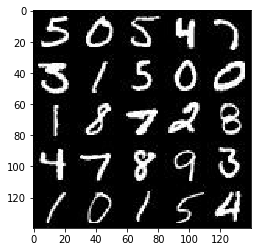

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

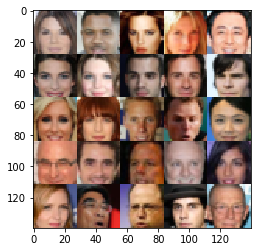

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    realInputImg = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name="realInputImg")
    inputZ = tf.placeholder(tf.float32, shape=[None, z_dim], name="inputZ")
    learningRate = tf.placeholder(tf.float32, name="learningRate")

    return realInputImg, inputZ, learningRate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.1

    with tf.variable_scope('discriminator', reuse=reuse):
        # first conv layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        # second conv layer
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # third conv layer
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=0.5)

        
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # shape = 7x7x512
        layer1 = tf.layers.dense(z, 7*7*512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        #conv layer 1
        # shape = 14x14x256
        conv1 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same', activation=None)
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        #conv layer 2
        # shape = 28x28x128
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)   
        
        #o/p layer
        # shape = 28x28x5

        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 3, strides=1, padding='same', activation=None)
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    gen_output = generator(input_z, out_channel_dim)
    
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(gen_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_real,
            labels = tf.ones_like(disc_output_real) * (1 - smooth)
        )
    )
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.zeros_like(disc_output_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake


    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_fake)
        )
    )
    
    return disc_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # discriminator and generator variables
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)

        return disc_train_opt, gen_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    
    steps = 0
    total_steps = epoch_count * batch_size
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


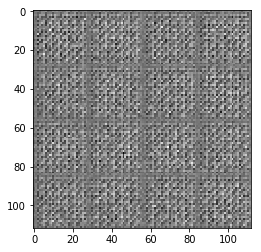

Epoch 1/2... Generator Loss: 1.9547 Discriminator Loss: 0.5341...
Epoch 1/2... Generator Loss: 9.1692 Discriminator Loss: 0.7855...
Epoch 1/2... Generator Loss: 0.0215 Discriminator Loss: 4.6284...
Epoch 1/2... Generator Loss: 4.4025 Discriminator Loss: 0.8146...
Epoch 1/2... Generator Loss: 1.1935 Discriminator Loss: 1.8769...
Epoch 1/2... Generator Loss: 0.7451 Discriminator Loss: 1.4756...
Epoch 1/2... Generator Loss: 1.1950 Discriminator Loss: 1.8232...
Epoch 1/2... Generator Loss: 0.9477 Discriminator Loss: 1.7366...
Epoch 1/2... Generator Loss: 1.1433 Discriminator Loss: 1.7694...
Epoch 1/2... Generator Loss: 0.4969 Discriminator Loss: 1.5205...


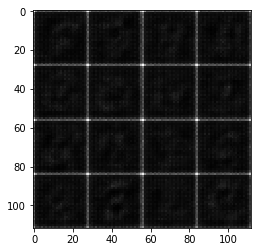

Epoch 1/2... Generator Loss: 0.2526 Discriminator Loss: 1.9625...
Epoch 1/2... Generator Loss: 0.3377 Discriminator Loss: 1.7890...
Epoch 1/2... Generator Loss: 0.3201 Discriminator Loss: 1.7255...
Epoch 1/2... Generator Loss: 0.3218 Discriminator Loss: 1.7397...
Epoch 1/2... Generator Loss: 0.2233 Discriminator Loss: 2.0144...
Epoch 1/2... Generator Loss: 0.6952 Discriminator Loss: 1.3819...
Epoch 1/2... Generator Loss: 1.2631 Discriminator Loss: 1.2875...
Epoch 1/2... Generator Loss: 0.9901 Discriminator Loss: 1.2311...
Epoch 1/2... Generator Loss: 1.3275 Discriminator Loss: 1.6108...
Epoch 1/2... Generator Loss: 1.2048 Discriminator Loss: 1.3453...


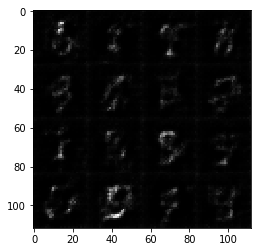

Epoch 1/2... Generator Loss: 0.5983 Discriminator Loss: 1.3417...
Epoch 1/2... Generator Loss: 0.6232 Discriminator Loss: 1.2358...
Epoch 1/2... Generator Loss: 0.4294 Discriminator Loss: 1.4961...
Epoch 1/2... Generator Loss: 0.4598 Discriminator Loss: 1.4859...
Epoch 1/2... Generator Loss: 0.3560 Discriminator Loss: 1.6416...
Epoch 1/2... Generator Loss: 0.4262 Discriminator Loss: 1.5182...
Epoch 1/2... Generator Loss: 0.5432 Discriminator Loss: 1.3612...
Epoch 1/2... Generator Loss: 2.2112 Discriminator Loss: 1.4006...
Epoch 1/2... Generator Loss: 0.9663 Discriminator Loss: 0.9982...
Epoch 1/2... Generator Loss: 0.9369 Discriminator Loss: 0.9556...


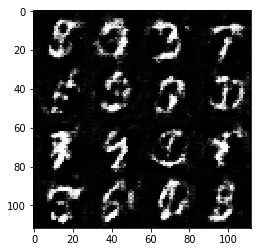

Epoch 1/2... Generator Loss: 2.6298 Discriminator Loss: 1.5027...
Epoch 1/2... Generator Loss: 0.4882 Discriminator Loss: 1.4376...
Epoch 1/2... Generator Loss: 0.7341 Discriminator Loss: 1.1467...
Epoch 1/2... Generator Loss: 0.3686 Discriminator Loss: 1.8250...
Epoch 1/2... Generator Loss: 0.5363 Discriminator Loss: 1.3719...
Epoch 1/2... Generator Loss: 2.0582 Discriminator Loss: 1.2102...
Epoch 1/2... Generator Loss: 0.5404 Discriminator Loss: 1.3534...
Epoch 1/2... Generator Loss: 0.6178 Discriminator Loss: 1.2447...
Epoch 1/2... Generator Loss: 1.0512 Discriminator Loss: 1.0231...
Epoch 1/2... Generator Loss: 0.9276 Discriminator Loss: 1.2408...


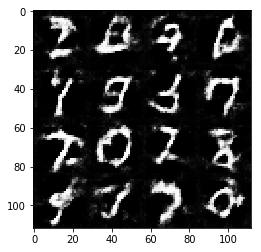

Epoch 1/2... Generator Loss: 0.9169 Discriminator Loss: 1.1022...
Epoch 1/2... Generator Loss: 1.6611 Discriminator Loss: 1.1321...
Epoch 1/2... Generator Loss: 0.4430 Discriminator Loss: 1.4764...
Epoch 1/2... Generator Loss: 0.3643 Discriminator Loss: 1.6225...
Epoch 1/2... Generator Loss: 0.3910 Discriminator Loss: 1.6373...
Epoch 1/2... Generator Loss: 0.3577 Discriminator Loss: 1.6075...
Epoch 1/2... Generator Loss: 1.1911 Discriminator Loss: 1.0447...
Epoch 1/2... Generator Loss: 1.3301 Discriminator Loss: 1.1127...
Epoch 1/2... Generator Loss: 0.3502 Discriminator Loss: 1.6873...
Epoch 1/2... Generator Loss: 0.8190 Discriminator Loss: 1.2811...


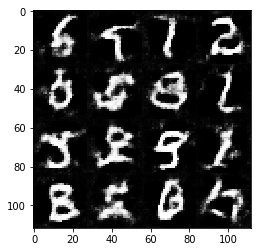

Epoch 1/2... Generator Loss: 1.2488 Discriminator Loss: 1.1493...
Epoch 1/2... Generator Loss: 0.8192 Discriminator Loss: 1.2917...
Epoch 1/2... Generator Loss: 0.6298 Discriminator Loss: 1.2570...
Epoch 1/2... Generator Loss: 0.2856 Discriminator Loss: 1.8153...
Epoch 1/2... Generator Loss: 0.4413 Discriminator Loss: 1.4879...
Epoch 1/2... Generator Loss: 1.1298 Discriminator Loss: 1.1404...
Epoch 1/2... Generator Loss: 0.6121 Discriminator Loss: 1.3428...
Epoch 1/2... Generator Loss: 1.3443 Discriminator Loss: 1.2764...
Epoch 1/2... Generator Loss: 1.1839 Discriminator Loss: 1.1572...
Epoch 1/2... Generator Loss: 1.3407 Discriminator Loss: 1.1817...


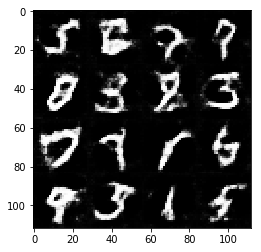

Epoch 1/2... Generator Loss: 0.9782 Discriminator Loss: 1.2553...
Epoch 1/2... Generator Loss: 1.1420 Discriminator Loss: 1.2228...
Epoch 1/2... Generator Loss: 1.1073 Discriminator Loss: 1.1172...
Epoch 1/2... Generator Loss: 1.3357 Discriminator Loss: 1.2982...
Epoch 1/2... Generator Loss: 0.3132 Discriminator Loss: 1.7825...
Epoch 1/2... Generator Loss: 0.9788 Discriminator Loss: 1.1331...
Epoch 1/2... Generator Loss: 1.1759 Discriminator Loss: 1.1895...
Epoch 1/2... Generator Loss: 0.2244 Discriminator Loss: 2.0922...
Epoch 1/2... Generator Loss: 0.7659 Discriminator Loss: 1.2441...
Epoch 1/2... Generator Loss: 1.1218 Discriminator Loss: 1.1219...


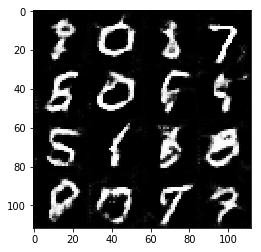

Epoch 1/2... Generator Loss: 1.1852 Discriminator Loss: 1.0717...
Epoch 1/2... Generator Loss: 0.4403 Discriminator Loss: 1.5481...
Epoch 1/2... Generator Loss: 0.3519 Discriminator Loss: 1.6653...
Epoch 1/2... Generator Loss: 0.4172 Discriminator Loss: 1.5219...
Epoch 1/2... Generator Loss: 0.2972 Discriminator Loss: 1.7952...
Epoch 1/2... Generator Loss: 0.3574 Discriminator Loss: 1.6483...
Epoch 1/2... Generator Loss: 1.0385 Discriminator Loss: 1.2280...
Epoch 1/2... Generator Loss: 0.5524 Discriminator Loss: 1.3915...
Epoch 1/2... Generator Loss: 0.7105 Discriminator Loss: 1.1941...
Epoch 1/2... Generator Loss: 1.1299 Discriminator Loss: 1.1703...


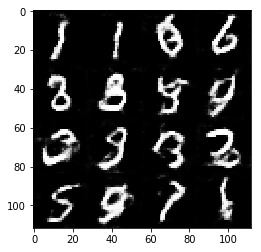

Epoch 1/2... Generator Loss: 0.4422 Discriminator Loss: 1.4952...
Epoch 1/2... Generator Loss: 1.9376 Discriminator Loss: 1.3622...
Epoch 1/2... Generator Loss: 0.9195 Discriminator Loss: 1.1597...
Epoch 1/2... Generator Loss: 0.2774 Discriminator Loss: 1.8879...
Epoch 1/2... Generator Loss: 0.3986 Discriminator Loss: 1.5815...
Epoch 1/2... Generator Loss: 0.9519 Discriminator Loss: 1.0062...
Epoch 1/2... Generator Loss: 1.2612 Discriminator Loss: 1.1115...
Epoch 1/2... Generator Loss: 0.5405 Discriminator Loss: 1.3424...
Epoch 1/2... Generator Loss: 0.2942 Discriminator Loss: 1.8436...
Epoch 1/2... Generator Loss: 0.9228 Discriminator Loss: 1.0525...


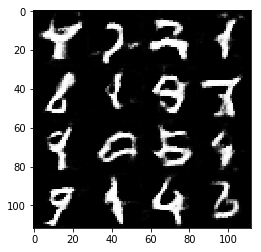

Epoch 1/2... Generator Loss: 0.8545 Discriminator Loss: 1.0464...
Epoch 1/2... Generator Loss: 0.3958 Discriminator Loss: 1.5383...
Epoch 1/2... Generator Loss: 0.5913 Discriminator Loss: 1.3618...
Epoch 1/2... Generator Loss: 0.5326 Discriminator Loss: 1.3567...
Epoch 1/2... Generator Loss: 1.0517 Discriminator Loss: 1.1405...
Epoch 1/2... Generator Loss: 1.6091 Discriminator Loss: 1.2352...
Epoch 1/2... Generator Loss: 1.2845 Discriminator Loss: 0.9956...
Epoch 1/2... Generator Loss: 0.5854 Discriminator Loss: 1.2695...
Epoch 1/2... Generator Loss: 2.3886 Discriminator Loss: 1.8816...
Epoch 1/2... Generator Loss: 0.9395 Discriminator Loss: 1.1641...


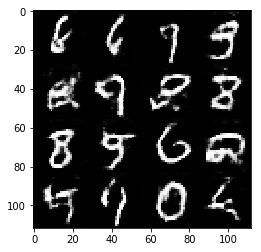

Epoch 1/2... Generator Loss: 0.5807 Discriminator Loss: 1.2941...
Epoch 1/2... Generator Loss: 0.3334 Discriminator Loss: 1.7052...
Epoch 1/2... Generator Loss: 1.2074 Discriminator Loss: 0.9496...
Epoch 1/2... Generator Loss: 0.8566 Discriminator Loss: 1.1440...
Epoch 1/2... Generator Loss: 0.8929 Discriminator Loss: 1.1379...
Epoch 1/2... Generator Loss: 2.1478 Discriminator Loss: 1.4997...
Epoch 1/2... Generator Loss: 1.0197 Discriminator Loss: 1.0943...
Epoch 1/2... Generator Loss: 0.2767 Discriminator Loss: 1.8593...
Epoch 1/2... Generator Loss: 0.6827 Discriminator Loss: 1.1984...
Epoch 1/2... Generator Loss: 1.4165 Discriminator Loss: 0.8991...


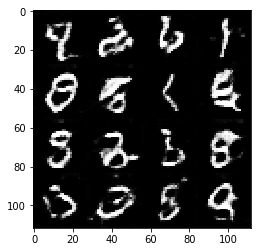

Epoch 1/2... Generator Loss: 1.2892 Discriminator Loss: 1.0061...
Epoch 1/2... Generator Loss: 1.0294 Discriminator Loss: 1.0786...
Epoch 1/2... Generator Loss: 1.5308 Discriminator Loss: 1.1598...
Epoch 1/2... Generator Loss: 0.9846 Discriminator Loss: 0.9557...
Epoch 1/2... Generator Loss: 1.9456 Discriminator Loss: 1.6498...
Epoch 1/2... Generator Loss: 1.1294 Discriminator Loss: 1.1591...
Epoch 1/2... Generator Loss: 0.6725 Discriminator Loss: 1.2509...
Epoch 1/2... Generator Loss: 0.6524 Discriminator Loss: 1.2559...
Epoch 1/2... Generator Loss: 2.5200 Discriminator Loss: 1.1525...
Epoch 1/2... Generator Loss: 1.1052 Discriminator Loss: 1.0204...


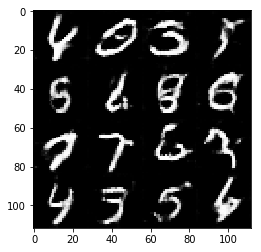

Epoch 1/2... Generator Loss: 0.8261 Discriminator Loss: 1.0899...
Epoch 1/2... Generator Loss: 1.4214 Discriminator Loss: 1.0214...
Epoch 1/2... Generator Loss: 1.2060 Discriminator Loss: 1.3164...
Epoch 1/2... Generator Loss: 0.4085 Discriminator Loss: 1.5070...
Epoch 1/2... Generator Loss: 0.7356 Discriminator Loss: 1.1698...
Epoch 1/2... Generator Loss: 0.3836 Discriminator Loss: 1.5854...
Epoch 1/2... Generator Loss: 0.5220 Discriminator Loss: 1.3688...
Epoch 1/2... Generator Loss: 0.9908 Discriminator Loss: 1.0302...
Epoch 1/2... Generator Loss: 1.8142 Discriminator Loss: 0.9122...
Epoch 1/2... Generator Loss: 1.2777 Discriminator Loss: 1.0045...


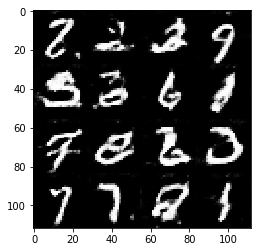

Epoch 1/2... Generator Loss: 1.8242 Discriminator Loss: 1.3075...
Epoch 1/2... Generator Loss: 0.7876 Discriminator Loss: 1.1402...
Epoch 1/2... Generator Loss: 0.5628 Discriminator Loss: 1.3109...
Epoch 1/2... Generator Loss: 0.5221 Discriminator Loss: 1.3475...
Epoch 1/2... Generator Loss: 0.4253 Discriminator Loss: 1.5066...
Epoch 1/2... Generator Loss: 0.6476 Discriminator Loss: 1.2267...
Epoch 1/2... Generator Loss: 1.7249 Discriminator Loss: 1.0123...
Epoch 1/2... Generator Loss: 0.7454 Discriminator Loss: 1.2075...
Epoch 1/2... Generator Loss: 0.5188 Discriminator Loss: 1.4083...
Epoch 1/2... Generator Loss: 0.3381 Discriminator Loss: 1.6486...


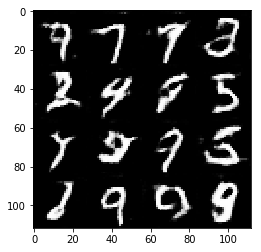

Epoch 1/2... Generator Loss: 0.6723 Discriminator Loss: 1.2380...
Epoch 1/2... Generator Loss: 1.5669 Discriminator Loss: 0.8140...
Epoch 1/2... Generator Loss: 1.8428 Discriminator Loss: 1.0457...
Epoch 1/2... Generator Loss: 1.2959 Discriminator Loss: 0.9811...
Epoch 1/2... Generator Loss: 1.2602 Discriminator Loss: 1.1280...
Epoch 1/2... Generator Loss: 1.4125 Discriminator Loss: 1.2562...
Epoch 1/2... Generator Loss: 1.0770 Discriminator Loss: 0.9765...
Epoch 1/2... Generator Loss: 1.1684 Discriminator Loss: 1.0584...
Epoch 1/2... Generator Loss: 0.4407 Discriminator Loss: 1.4999...
Epoch 1/2... Generator Loss: 0.7517 Discriminator Loss: 1.1607...


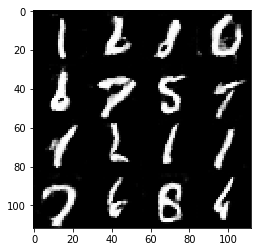

Epoch 1/2... Generator Loss: 0.5499 Discriminator Loss: 1.3261...
Epoch 1/2... Generator Loss: 0.3827 Discriminator Loss: 1.6341...
Epoch 1/2... Generator Loss: 0.6904 Discriminator Loss: 1.1957...
Epoch 1/2... Generator Loss: 1.0994 Discriminator Loss: 1.0643...
Epoch 1/2... Generator Loss: 1.2058 Discriminator Loss: 1.0100...
Epoch 1/2... Generator Loss: 0.6454 Discriminator Loss: 1.1979...
Epoch 1/2... Generator Loss: 0.5145 Discriminator Loss: 1.3674...
Epoch 1/2... Generator Loss: 0.6723 Discriminator Loss: 1.1719...
Epoch 1/2... Generator Loss: 1.3447 Discriminator Loss: 1.0675...
Epoch 1/2... Generator Loss: 0.9963 Discriminator Loss: 1.1254...


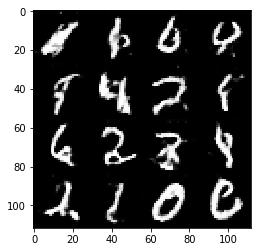

Epoch 1/2... Generator Loss: 1.5449 Discriminator Loss: 0.9897...
Epoch 1/2... Generator Loss: 1.1819 Discriminator Loss: 0.8957...
Epoch 1/2... Generator Loss: 0.6170 Discriminator Loss: 1.2645...
Epoch 1/2... Generator Loss: 0.4426 Discriminator Loss: 1.5195...
Epoch 1/2... Generator Loss: 0.3073 Discriminator Loss: 1.7821...
Epoch 1/2... Generator Loss: 0.9879 Discriminator Loss: 0.9412...
Epoch 1/2... Generator Loss: 0.8373 Discriminator Loss: 1.1114...
Epoch 1/2... Generator Loss: 0.4146 Discriminator Loss: 1.5543...
Epoch 1/2... Generator Loss: 0.9183 Discriminator Loss: 1.0198...
Epoch 1/2... Generator Loss: 0.6601 Discriminator Loss: 1.2048...


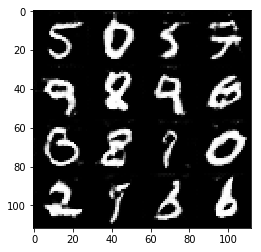

Epoch 1/2... Generator Loss: 0.4375 Discriminator Loss: 1.4764...
Epoch 1/2... Generator Loss: 0.4496 Discriminator Loss: 1.4693...
Epoch 1/2... Generator Loss: 0.4908 Discriminator Loss: 1.4340...
Epoch 1/2... Generator Loss: 1.0943 Discriminator Loss: 0.9781...
Epoch 1/2... Generator Loss: 0.8549 Discriminator Loss: 1.1081...
Epoch 1/2... Generator Loss: 1.7097 Discriminator Loss: 0.9308...
Epoch 1/2... Generator Loss: 1.4685 Discriminator Loss: 0.9912...
Epoch 1/2... Generator Loss: 1.7229 Discriminator Loss: 0.8366...
Epoch 1/2... Generator Loss: 0.9206 Discriminator Loss: 1.0852...
Epoch 1/2... Generator Loss: 0.6835 Discriminator Loss: 1.1791...


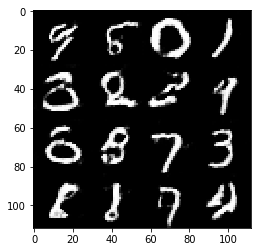

Epoch 1/2... Generator Loss: 1.1834 Discriminator Loss: 1.0477...
Epoch 1/2... Generator Loss: 0.4745 Discriminator Loss: 1.5348...
Epoch 1/2... Generator Loss: 0.5635 Discriminator Loss: 1.3130...
Epoch 1/2... Generator Loss: 0.6715 Discriminator Loss: 1.2313...
Epoch 1/2... Generator Loss: 1.1620 Discriminator Loss: 0.8922...
Epoch 1/2... Generator Loss: 1.2857 Discriminator Loss: 0.9252...
Epoch 1/2... Generator Loss: 1.7767 Discriminator Loss: 1.3802...
Epoch 2/2... Generator Loss: 1.2499 Discriminator Loss: 1.0131...
Epoch 2/2... Generator Loss: 0.8805 Discriminator Loss: 1.0110...
Epoch 2/2... Generator Loss: 0.6644 Discriminator Loss: 1.1957...


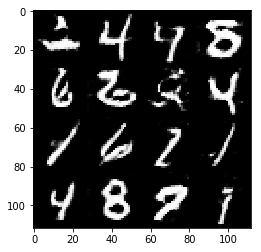

Epoch 2/2... Generator Loss: 0.4600 Discriminator Loss: 1.5086...
Epoch 2/2... Generator Loss: 0.5769 Discriminator Loss: 1.2405...
Epoch 2/2... Generator Loss: 0.7679 Discriminator Loss: 1.0886...
Epoch 2/2... Generator Loss: 0.5297 Discriminator Loss: 1.3630...
Epoch 2/2... Generator Loss: 0.4748 Discriminator Loss: 1.4902...
Epoch 2/2... Generator Loss: 0.8357 Discriminator Loss: 1.0107...
Epoch 2/2... Generator Loss: 1.7592 Discriminator Loss: 1.1635...
Epoch 2/2... Generator Loss: 1.3904 Discriminator Loss: 0.8676...
Epoch 2/2... Generator Loss: 0.9068 Discriminator Loss: 0.9565...
Epoch 2/2... Generator Loss: 0.8543 Discriminator Loss: 1.0621...


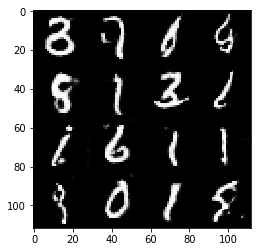

Epoch 2/2... Generator Loss: 1.2572 Discriminator Loss: 0.8883...
Epoch 2/2... Generator Loss: 0.8447 Discriminator Loss: 1.0118...
Epoch 2/2... Generator Loss: 0.9655 Discriminator Loss: 0.9403...
Epoch 2/2... Generator Loss: 0.9810 Discriminator Loss: 0.9584...
Epoch 2/2... Generator Loss: 1.1671 Discriminator Loss: 0.9546...
Epoch 2/2... Generator Loss: 1.5859 Discriminator Loss: 1.1498...
Epoch 2/2... Generator Loss: 0.8091 Discriminator Loss: 1.0456...
Epoch 2/2... Generator Loss: 0.3340 Discriminator Loss: 1.7356...
Epoch 2/2... Generator Loss: 0.7952 Discriminator Loss: 1.0641...
Epoch 2/2... Generator Loss: 1.3545 Discriminator Loss: 0.8342...


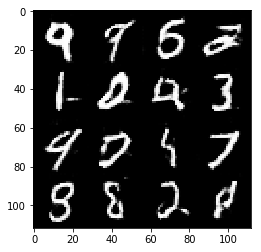

Epoch 2/2... Generator Loss: 1.6087 Discriminator Loss: 1.2349...
Epoch 2/2... Generator Loss: 1.3480 Discriminator Loss: 1.0318...
Epoch 2/2... Generator Loss: 0.5431 Discriminator Loss: 1.3171...
Epoch 2/2... Generator Loss: 1.2675 Discriminator Loss: 0.9986...
Epoch 2/2... Generator Loss: 0.4677 Discriminator Loss: 1.4194...
Epoch 2/2... Generator Loss: 0.5255 Discriminator Loss: 1.3997...
Epoch 2/2... Generator Loss: 1.2054 Discriminator Loss: 0.9258...
Epoch 2/2... Generator Loss: 1.4354 Discriminator Loss: 0.9386...
Epoch 2/2... Generator Loss: 1.3214 Discriminator Loss: 0.7786...
Epoch 2/2... Generator Loss: 1.0490 Discriminator Loss: 1.0341...


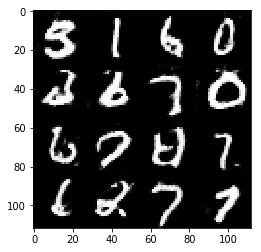

Epoch 2/2... Generator Loss: 0.4905 Discriminator Loss: 1.4329...
Epoch 2/2... Generator Loss: 2.0307 Discriminator Loss: 0.9717...
Epoch 2/2... Generator Loss: 1.3467 Discriminator Loss: 1.0812...
Epoch 2/2... Generator Loss: 0.5611 Discriminator Loss: 1.2647...
Epoch 2/2... Generator Loss: 0.9163 Discriminator Loss: 0.9545...
Epoch 2/2... Generator Loss: 0.6335 Discriminator Loss: 1.2636...
Epoch 2/2... Generator Loss: 0.5748 Discriminator Loss: 1.2839...
Epoch 2/2... Generator Loss: 0.6665 Discriminator Loss: 1.1959...
Epoch 2/2... Generator Loss: 1.5884 Discriminator Loss: 1.3156...
Epoch 2/2... Generator Loss: 0.7969 Discriminator Loss: 1.2119...


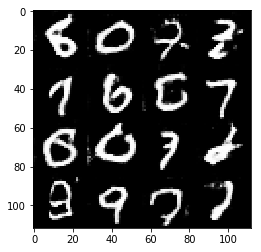

Epoch 2/2... Generator Loss: 0.7360 Discriminator Loss: 1.0972...
Epoch 2/2... Generator Loss: 1.1298 Discriminator Loss: 0.8082...
Epoch 2/2... Generator Loss: 0.4756 Discriminator Loss: 1.4662...
Epoch 2/2... Generator Loss: 0.2568 Discriminator Loss: 2.1437...
Epoch 2/2... Generator Loss: 1.3690 Discriminator Loss: 0.8123...
Epoch 2/2... Generator Loss: 1.6838 Discriminator Loss: 0.7388...
Epoch 2/2... Generator Loss: 0.5120 Discriminator Loss: 1.4256...
Epoch 2/2... Generator Loss: 0.5356 Discriminator Loss: 1.3058...
Epoch 2/2... Generator Loss: 0.6262 Discriminator Loss: 1.2464...
Epoch 2/2... Generator Loss: 1.6845 Discriminator Loss: 0.8896...


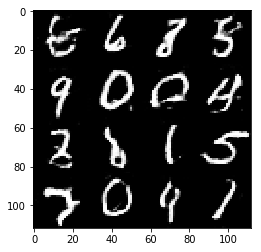

Epoch 2/2... Generator Loss: 1.1317 Discriminator Loss: 0.9057...
Epoch 2/2... Generator Loss: 0.5133 Discriminator Loss: 1.3806...
Epoch 2/2... Generator Loss: 1.3437 Discriminator Loss: 0.7771...
Epoch 2/2... Generator Loss: 1.7764 Discriminator Loss: 1.1618...
Epoch 2/2... Generator Loss: 0.9886 Discriminator Loss: 0.9871...
Epoch 2/2... Generator Loss: 0.3245 Discriminator Loss: 1.7953...
Epoch 2/2... Generator Loss: 1.2793 Discriminator Loss: 0.9271...
Epoch 2/2... Generator Loss: 2.0150 Discriminator Loss: 0.8397...
Epoch 2/2... Generator Loss: 1.7419 Discriminator Loss: 0.8148...
Epoch 2/2... Generator Loss: 1.3169 Discriminator Loss: 0.8743...


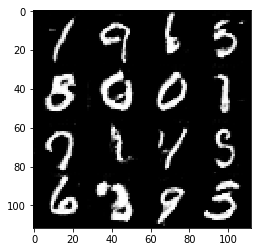

Epoch 2/2... Generator Loss: 0.5617 Discriminator Loss: 1.3337...
Epoch 2/2... Generator Loss: 0.7149 Discriminator Loss: 1.0919...
Epoch 2/2... Generator Loss: 0.7208 Discriminator Loss: 1.0975...
Epoch 2/2... Generator Loss: 0.4138 Discriminator Loss: 1.5719...
Epoch 2/2... Generator Loss: 0.9298 Discriminator Loss: 1.0164...
Epoch 2/2... Generator Loss: 1.6100 Discriminator Loss: 0.9272...
Epoch 2/2... Generator Loss: 0.9140 Discriminator Loss: 0.9508...
Epoch 2/2... Generator Loss: 2.1508 Discriminator Loss: 1.2154...
Epoch 2/2... Generator Loss: 1.5343 Discriminator Loss: 0.8896...
Epoch 2/2... Generator Loss: 0.7392 Discriminator Loss: 1.1790...


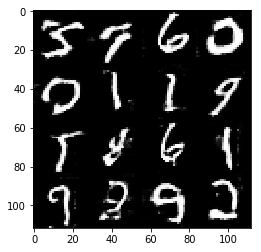

Epoch 2/2... Generator Loss: 0.6443 Discriminator Loss: 1.2016...
Epoch 2/2... Generator Loss: 1.4233 Discriminator Loss: 0.7918...
Epoch 2/2... Generator Loss: 0.8329 Discriminator Loss: 1.0025...
Epoch 2/2... Generator Loss: 2.0724 Discriminator Loss: 1.4133...
Epoch 2/2... Generator Loss: 0.4895 Discriminator Loss: 1.4037...
Epoch 2/2... Generator Loss: 1.2430 Discriminator Loss: 0.8507...
Epoch 2/2... Generator Loss: 0.8629 Discriminator Loss: 1.0161...
Epoch 2/2... Generator Loss: 1.8456 Discriminator Loss: 0.8206...
Epoch 2/2... Generator Loss: 0.7765 Discriminator Loss: 1.0947...
Epoch 2/2... Generator Loss: 1.1408 Discriminator Loss: 0.8242...


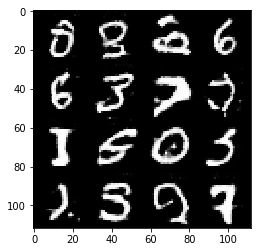

Epoch 2/2... Generator Loss: 1.6020 Discriminator Loss: 0.7599...
Epoch 2/2... Generator Loss: 1.4856 Discriminator Loss: 0.8909...
Epoch 2/2... Generator Loss: 0.7848 Discriminator Loss: 1.0989...
Epoch 2/2... Generator Loss: 2.8905 Discriminator Loss: 1.6881...
Epoch 2/2... Generator Loss: 0.8056 Discriminator Loss: 1.1681...
Epoch 2/2... Generator Loss: 2.1829 Discriminator Loss: 0.9687...
Epoch 2/2... Generator Loss: 1.1882 Discriminator Loss: 0.8154...
Epoch 2/2... Generator Loss: 0.4608 Discriminator Loss: 1.4914...
Epoch 2/2... Generator Loss: 1.2816 Discriminator Loss: 1.0033...
Epoch 2/2... Generator Loss: 1.4387 Discriminator Loss: 0.7922...


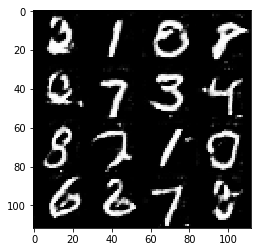

Epoch 2/2... Generator Loss: 1.3831 Discriminator Loss: 0.9761...
Epoch 2/2... Generator Loss: 1.1778 Discriminator Loss: 0.9627...
Epoch 2/2... Generator Loss: 1.7425 Discriminator Loss: 0.8837...
Epoch 2/2... Generator Loss: 0.9402 Discriminator Loss: 0.9970...
Epoch 2/2... Generator Loss: 0.6462 Discriminator Loss: 1.2726...
Epoch 2/2... Generator Loss: 1.9855 Discriminator Loss: 0.8893...
Epoch 2/2... Generator Loss: 1.7650 Discriminator Loss: 1.0198...
Epoch 2/2... Generator Loss: 1.1709 Discriminator Loss: 0.9077...
Epoch 2/2... Generator Loss: 1.5302 Discriminator Loss: 0.7606...
Epoch 2/2... Generator Loss: 1.6233 Discriminator Loss: 0.7788...


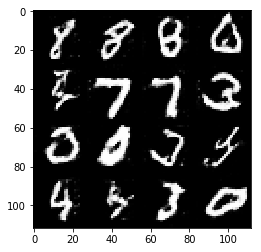

Epoch 2/2... Generator Loss: 0.9410 Discriminator Loss: 0.9215...
Epoch 2/2... Generator Loss: 1.6143 Discriminator Loss: 0.8180...
Epoch 2/2... Generator Loss: 1.7332 Discriminator Loss: 0.7326...
Epoch 2/2... Generator Loss: 1.4213 Discriminator Loss: 0.8038...
Epoch 2/2... Generator Loss: 1.6530 Discriminator Loss: 1.0979...
Epoch 2/2... Generator Loss: 0.5376 Discriminator Loss: 1.2944...
Epoch 2/2... Generator Loss: 1.8703 Discriminator Loss: 0.9179...
Epoch 2/2... Generator Loss: 1.8962 Discriminator Loss: 0.7251...
Epoch 2/2... Generator Loss: 1.5959 Discriminator Loss: 0.9887...
Epoch 2/2... Generator Loss: 1.5407 Discriminator Loss: 1.0082...


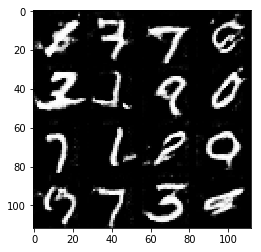

Epoch 2/2... Generator Loss: 1.3066 Discriminator Loss: 0.8294...
Epoch 2/2... Generator Loss: 0.6893 Discriminator Loss: 1.1743...
Epoch 2/2... Generator Loss: 1.3892 Discriminator Loss: 0.8123...
Epoch 2/2... Generator Loss: 2.5293 Discriminator Loss: 1.0876...
Epoch 2/2... Generator Loss: 0.8971 Discriminator Loss: 0.9759...
Epoch 2/2... Generator Loss: 1.2608 Discriminator Loss: 0.7684...
Epoch 2/2... Generator Loss: 1.1453 Discriminator Loss: 0.8466...
Epoch 2/2... Generator Loss: 0.3599 Discriminator Loss: 1.7248...
Epoch 2/2... Generator Loss: 0.8784 Discriminator Loss: 0.9814...
Epoch 2/2... Generator Loss: 0.7996 Discriminator Loss: 1.1706...


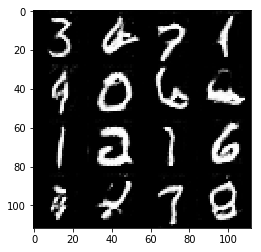

Epoch 2/2... Generator Loss: 0.3771 Discriminator Loss: 1.7305...
Epoch 2/2... Generator Loss: 0.5414 Discriminator Loss: 1.5700...
Epoch 2/2... Generator Loss: 1.7598 Discriminator Loss: 1.0193...
Epoch 2/2... Generator Loss: 2.4577 Discriminator Loss: 1.3867...
Epoch 2/2... Generator Loss: 0.6924 Discriminator Loss: 1.1820...
Epoch 2/2... Generator Loss: 1.8731 Discriminator Loss: 0.8738...
Epoch 2/2... Generator Loss: 1.2928 Discriminator Loss: 0.7546...
Epoch 2/2... Generator Loss: 1.5588 Discriminator Loss: 0.6847...
Epoch 2/2... Generator Loss: 0.6983 Discriminator Loss: 1.1127...
Epoch 2/2... Generator Loss: 0.5224 Discriminator Loss: 1.4859...


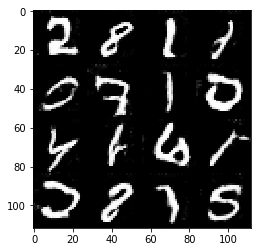

Epoch 2/2... Generator Loss: 1.1247 Discriminator Loss: 0.8069...
Epoch 2/2... Generator Loss: 0.6664 Discriminator Loss: 1.1510...
Epoch 2/2... Generator Loss: 0.8447 Discriminator Loss: 1.0217...
Epoch 2/2... Generator Loss: 0.8117 Discriminator Loss: 1.0855...
Epoch 2/2... Generator Loss: 2.1406 Discriminator Loss: 1.1753...
Epoch 2/2... Generator Loss: 1.9054 Discriminator Loss: 0.7159...
Epoch 2/2... Generator Loss: 0.9034 Discriminator Loss: 0.9486...
Epoch 2/2... Generator Loss: 0.8603 Discriminator Loss: 0.9641...
Epoch 2/2... Generator Loss: 2.1494 Discriminator Loss: 1.1691...
Epoch 2/2... Generator Loss: 1.4102 Discriminator Loss: 0.8447...


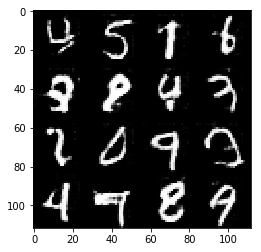

Epoch 2/2... Generator Loss: 0.9660 Discriminator Loss: 0.8914...
Epoch 2/2... Generator Loss: 1.1686 Discriminator Loss: 0.8072...
Epoch 2/2... Generator Loss: 1.9376 Discriminator Loss: 0.8417...
Epoch 2/2... Generator Loss: 0.5730 Discriminator Loss: 1.3978...
Epoch 2/2... Generator Loss: 0.6007 Discriminator Loss: 1.2836...
Epoch 2/2... Generator Loss: 1.1858 Discriminator Loss: 0.8014...
Epoch 2/2... Generator Loss: 0.7013 Discriminator Loss: 1.1574...
Epoch 2/2... Generator Loss: 1.9852 Discriminator Loss: 0.9447...
Epoch 2/2... Generator Loss: 1.6662 Discriminator Loss: 0.9353...
Epoch 2/2... Generator Loss: 1.1156 Discriminator Loss: 0.8251...


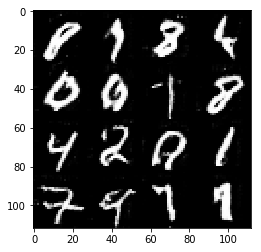

Epoch 2/2... Generator Loss: 0.5809 Discriminator Loss: 1.4319...
Epoch 2/2... Generator Loss: 1.1960 Discriminator Loss: 0.7983...
Epoch 2/2... Generator Loss: 1.3050 Discriminator Loss: 0.8539...
Epoch 2/2... Generator Loss: 0.9252 Discriminator Loss: 0.9176...
Epoch 2/2... Generator Loss: 1.8791 Discriminator Loss: 0.5899...
Epoch 2/2... Generator Loss: 1.1347 Discriminator Loss: 0.8043...
Epoch 2/2... Generator Loss: 0.6354 Discriminator Loss: 1.2548...
Epoch 2/2... Generator Loss: 0.6090 Discriminator Loss: 1.2927...
Epoch 2/2... Generator Loss: 1.4182 Discriminator Loss: 0.6822...
Epoch 2/2... Generator Loss: 1.8085 Discriminator Loss: 0.9746...


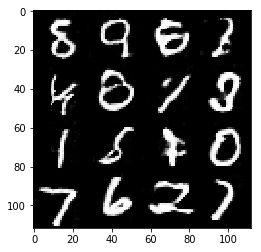

Epoch 2/2... Generator Loss: 0.6219 Discriminator Loss: 1.2364...
Epoch 2/2... Generator Loss: 1.5638 Discriminator Loss: 0.6961...
Epoch 2/2... Generator Loss: 2.4903 Discriminator Loss: 0.6770...
Epoch 2/2... Generator Loss: 0.9866 Discriminator Loss: 0.9266...
Epoch 2/2... Generator Loss: 0.9023 Discriminator Loss: 0.9382...
Epoch 2/2... Generator Loss: 0.8310 Discriminator Loss: 1.0468...
Epoch 2/2... Generator Loss: 0.5627 Discriminator Loss: 1.2732...
Epoch 2/2... Generator Loss: 0.5753 Discriminator Loss: 1.2881...
Epoch 2/2... Generator Loss: 0.2882 Discriminator Loss: 1.8895...
Epoch 2/2... Generator Loss: 1.5222 Discriminator Loss: 0.7390...


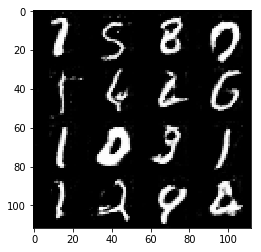

Epoch 2/2... Generator Loss: 0.3724 Discriminator Loss: 1.7308...
Epoch 2/2... Generator Loss: 0.6884 Discriminator Loss: 1.1201...
Epoch 2/2... Generator Loss: 0.5679 Discriminator Loss: 1.3145...
Epoch 2/2... Generator Loss: 1.1954 Discriminator Loss: 0.7976...
Epoch 2/2... Generator Loss: 2.1461 Discriminator Loss: 0.8898...
Epoch 2/2... Generator Loss: 0.7492 Discriminator Loss: 1.1805...
Epoch 2/2... Generator Loss: 0.2881 Discriminator Loss: 1.9449...
Epoch 2/2... Generator Loss: 0.7802 Discriminator Loss: 1.0924...
Epoch 2/2... Generator Loss: 0.7874 Discriminator Loss: 1.0624...
Epoch 2/2... Generator Loss: 1.1897 Discriminator Loss: 0.8324...


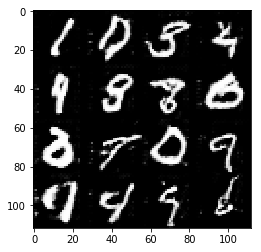

Epoch 2/2... Generator Loss: 0.8864 Discriminator Loss: 0.9911...
Epoch 2/2... Generator Loss: 1.1857 Discriminator Loss: 0.7672...
Epoch 2/2... Generator Loss: 1.2614 Discriminator Loss: 0.7348...
Epoch 2/2... Generator Loss: 0.4622 Discriminator Loss: 1.5247...
Epoch 2/2... Generator Loss: 0.9087 Discriminator Loss: 0.9535...


In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


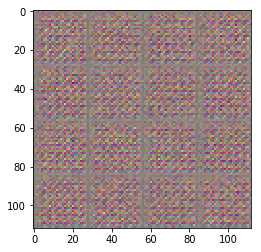

Epoch 1/1... Generator Loss: 3.3957 Discriminator Loss: 0.9607...
Epoch 1/1... Generator Loss: 0.1021 Discriminator Loss: 3.1586...
Epoch 1/1... Generator Loss: 0.7390 Discriminator Loss: 1.2987...
Epoch 1/1... Generator Loss: 3.4167 Discriminator Loss: 1.9004...
Epoch 1/1... Generator Loss: 2.1745 Discriminator Loss: 1.5798...
Epoch 1/1... Generator Loss: 0.3984 Discriminator Loss: 1.8488...
Epoch 1/1... Generator Loss: 0.1904 Discriminator Loss: 2.3675...
Epoch 1/1... Generator Loss: 0.1677 Discriminator Loss: 2.4168...
Epoch 1/1... Generator Loss: 0.4128 Discriminator Loss: 1.5569...
Epoch 1/1... Generator Loss: 0.7033 Discriminator Loss: 1.2157...


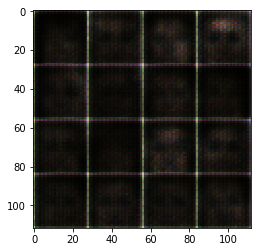

Epoch 1/1... Generator Loss: 0.5469 Discriminator Loss: 1.3528...
Epoch 1/1... Generator Loss: 0.5955 Discriminator Loss: 1.3111...
Epoch 1/1... Generator Loss: 0.6361 Discriminator Loss: 1.1707...
Epoch 1/1... Generator Loss: 0.2813 Discriminator Loss: 1.8982...
Epoch 1/1... Generator Loss: 0.3102 Discriminator Loss: 1.7699...
Epoch 1/1... Generator Loss: 0.1336 Discriminator Loss: 2.5178...
Epoch 1/1... Generator Loss: 1.0392 Discriminator Loss: 0.9019...
Epoch 1/1... Generator Loss: 0.6468 Discriminator Loss: 1.1930...
Epoch 1/1... Generator Loss: 1.0569 Discriminator Loss: 0.8663...
Epoch 1/1... Generator Loss: 0.5654 Discriminator Loss: 1.2732...


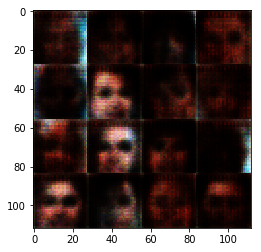

Epoch 1/1... Generator Loss: 1.1564 Discriminator Loss: 0.8490...
Epoch 1/1... Generator Loss: 1.8318 Discriminator Loss: 0.6216...
Epoch 1/1... Generator Loss: 4.6066 Discriminator Loss: 0.9766...
Epoch 1/1... Generator Loss: 0.8356 Discriminator Loss: 1.3925...
Epoch 1/1... Generator Loss: 2.1409 Discriminator Loss: 0.9101...
Epoch 1/1... Generator Loss: 1.9557 Discriminator Loss: 1.2393...
Epoch 1/1... Generator Loss: 1.8074 Discriminator Loss: 1.1535...
Epoch 1/1... Generator Loss: 0.6462 Discriminator Loss: 1.1879...
Epoch 1/1... Generator Loss: 3.2617 Discriminator Loss: 0.5484...
Epoch 1/1... Generator Loss: 0.9095 Discriminator Loss: 1.7422...


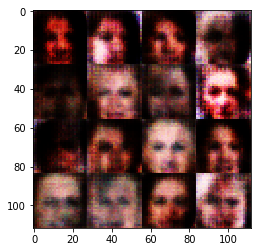

Epoch 1/1... Generator Loss: 1.7193 Discriminator Loss: 0.6588...
Epoch 1/1... Generator Loss: 1.2087 Discriminator Loss: 1.7807...
Epoch 1/1... Generator Loss: 1.5554 Discriminator Loss: 1.4225...
Epoch 1/1... Generator Loss: 1.8963 Discriminator Loss: 1.2271...
Epoch 1/1... Generator Loss: 1.4514 Discriminator Loss: 1.4668...
Epoch 1/1... Generator Loss: 2.4973 Discriminator Loss: 0.5751...
Epoch 1/1... Generator Loss: 2.1112 Discriminator Loss: 1.1296...
Epoch 1/1... Generator Loss: 1.1205 Discriminator Loss: 0.8365...
Epoch 1/1... Generator Loss: 0.4088 Discriminator Loss: 1.5533...
Epoch 1/1... Generator Loss: 3.2463 Discriminator Loss: 2.0579...


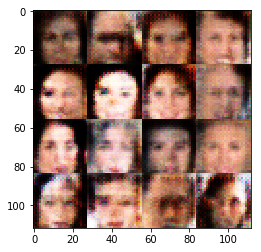

Epoch 1/1... Generator Loss: 1.4975 Discriminator Loss: 0.8979...
Epoch 1/1... Generator Loss: 0.3770 Discriminator Loss: 1.5840...
Epoch 1/1... Generator Loss: 1.1557 Discriminator Loss: 0.8264...
Epoch 1/1... Generator Loss: 2.8022 Discriminator Loss: 0.9921...
Epoch 1/1... Generator Loss: 1.1367 Discriminator Loss: 1.8800...
Epoch 1/1... Generator Loss: 1.9220 Discriminator Loss: 0.7397...
Epoch 1/1... Generator Loss: 1.3119 Discriminator Loss: 0.7868...
Epoch 1/1... Generator Loss: 0.6764 Discriminator Loss: 1.1568...
Epoch 1/1... Generator Loss: 1.7414 Discriminator Loss: 0.6522...
Epoch 1/1... Generator Loss: 0.6105 Discriminator Loss: 1.1728...


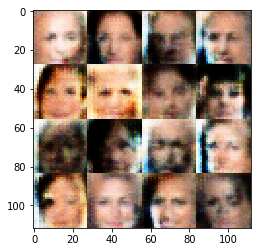

Epoch 1/1... Generator Loss: 2.7117 Discriminator Loss: 0.6264...
Epoch 1/1... Generator Loss: 1.5373 Discriminator Loss: 0.7444...
Epoch 1/1... Generator Loss: 1.8149 Discriminator Loss: 0.7180...
Epoch 1/1... Generator Loss: 0.2119 Discriminator Loss: 2.2735...
Epoch 1/1... Generator Loss: 0.3870 Discriminator Loss: 1.5846...
Epoch 1/1... Generator Loss: 0.7362 Discriminator Loss: 1.0453...
Epoch 1/1... Generator Loss: 2.6492 Discriminator Loss: 1.6108...
Epoch 1/1... Generator Loss: 0.7371 Discriminator Loss: 1.0659...
Epoch 1/1... Generator Loss: 0.2103 Discriminator Loss: 2.0744...
Epoch 1/1... Generator Loss: 1.3001 Discriminator Loss: 1.1992...


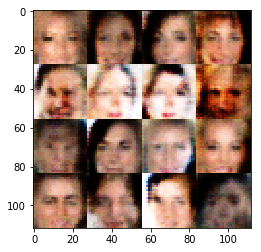

Epoch 1/1... Generator Loss: 1.1245 Discriminator Loss: 0.8174...
Epoch 1/1... Generator Loss: 0.8226 Discriminator Loss: 1.1066...
Epoch 1/1... Generator Loss: 2.5624 Discriminator Loss: 0.8182...
Epoch 1/1... Generator Loss: 0.6688 Discriminator Loss: 1.1187...
Epoch 1/1... Generator Loss: 1.3081 Discriminator Loss: 0.7314...
Epoch 1/1... Generator Loss: 0.5078 Discriminator Loss: 1.3688...
Epoch 1/1... Generator Loss: 0.7398 Discriminator Loss: 1.3113...
Epoch 1/1... Generator Loss: 2.8565 Discriminator Loss: 1.6359...
Epoch 1/1... Generator Loss: 2.9210 Discriminator Loss: 0.5771...
Epoch 1/1... Generator Loss: 2.4057 Discriminator Loss: 1.0097...


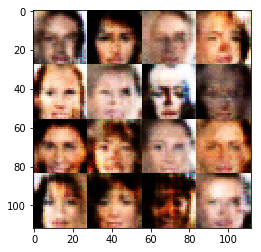

Epoch 1/1... Generator Loss: 2.0323 Discriminator Loss: 2.0120...
Epoch 1/1... Generator Loss: 0.6489 Discriminator Loss: 1.2810...
Epoch 1/1... Generator Loss: 3.2021 Discriminator Loss: 0.6582...
Epoch 1/1... Generator Loss: 0.9866 Discriminator Loss: 0.8951...
Epoch 1/1... Generator Loss: 0.1838 Discriminator Loss: 2.1942...
Epoch 1/1... Generator Loss: 1.3709 Discriminator Loss: 0.8227...
Epoch 1/1... Generator Loss: 2.0592 Discriminator Loss: 0.5369...
Epoch 1/1... Generator Loss: 2.6534 Discriminator Loss: 0.5776...
Epoch 1/1... Generator Loss: 2.3152 Discriminator Loss: 0.9135...
Epoch 1/1... Generator Loss: 2.3924 Discriminator Loss: 0.9860...


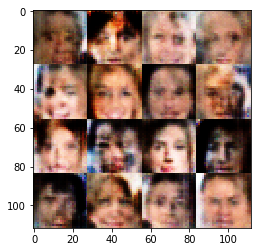

Epoch 1/1... Generator Loss: 1.9198 Discriminator Loss: 0.9537...
Epoch 1/1... Generator Loss: 1.8563 Discriminator Loss: 0.9222...
Epoch 1/1... Generator Loss: 2.4396 Discriminator Loss: 1.0409...
Epoch 1/1... Generator Loss: 1.0566 Discriminator Loss: 0.8912...
Epoch 1/1... Generator Loss: 0.8786 Discriminator Loss: 0.9547...
Epoch 1/1... Generator Loss: 0.8835 Discriminator Loss: 0.9333...
Epoch 1/1... Generator Loss: 0.4535 Discriminator Loss: 1.4042...
Epoch 1/1... Generator Loss: 2.0667 Discriminator Loss: 2.5994...
Epoch 1/1... Generator Loss: 4.4125 Discriminator Loss: 1.1343...
Epoch 1/1... Generator Loss: 1.0369 Discriminator Loss: 0.8401...


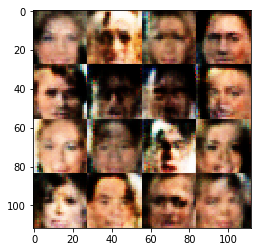

Epoch 1/1... Generator Loss: 3.0518 Discriminator Loss: 0.5095...
Epoch 1/1... Generator Loss: 1.0635 Discriminator Loss: 1.6362...
Epoch 1/1... Generator Loss: 1.9254 Discriminator Loss: 0.6306...
Epoch 1/1... Generator Loss: 1.7863 Discriminator Loss: 0.6126...
Epoch 1/1... Generator Loss: 3.1824 Discriminator Loss: 0.7533...
Epoch 1/1... Generator Loss: 1.9687 Discriminator Loss: 2.1399...
Epoch 1/1... Generator Loss: 0.7845 Discriminator Loss: 1.0427...
Epoch 1/1... Generator Loss: 2.6540 Discriminator Loss: 1.5725...
Epoch 1/1... Generator Loss: 2.2196 Discriminator Loss: 1.5175...
Epoch 1/1... Generator Loss: 1.7677 Discriminator Loss: 1.0138...


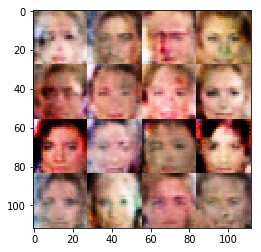

Epoch 1/1... Generator Loss: 0.8261 Discriminator Loss: 0.9730...
Epoch 1/1... Generator Loss: 0.9241 Discriminator Loss: 0.9247...
Epoch 1/1... Generator Loss: 0.9708 Discriminator Loss: 1.2641...
Epoch 1/1... Generator Loss: 0.1997 Discriminator Loss: 2.1451...
Epoch 1/1... Generator Loss: 2.0804 Discriminator Loss: 0.9168...
Epoch 1/1... Generator Loss: 0.7525 Discriminator Loss: 1.0684...
Epoch 1/1... Generator Loss: 2.4530 Discriminator Loss: 1.2044...
Epoch 1/1... Generator Loss: 1.1962 Discriminator Loss: 0.8132...
Epoch 1/1... Generator Loss: 0.9656 Discriminator Loss: 0.9146...
Epoch 1/1... Generator Loss: 2.0088 Discriminator Loss: 0.5107...


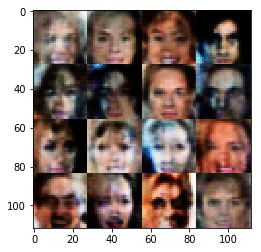

Epoch 1/1... Generator Loss: 0.5400 Discriminator Loss: 1.3436...
Epoch 1/1... Generator Loss: 0.9083 Discriminator Loss: 0.9224...
Epoch 1/1... Generator Loss: 0.4389 Discriminator Loss: 1.4100...
Epoch 1/1... Generator Loss: 1.6915 Discriminator Loss: 0.7084...
Epoch 1/1... Generator Loss: 0.8693 Discriminator Loss: 0.9985...
Epoch 1/1... Generator Loss: 1.3990 Discriminator Loss: 0.6881...
Epoch 1/1... Generator Loss: 2.3219 Discriminator Loss: 0.6343...
Epoch 1/1... Generator Loss: 0.4329 Discriminator Loss: 1.4915...
Epoch 1/1... Generator Loss: 1.1440 Discriminator Loss: 0.7753...
Epoch 1/1... Generator Loss: 0.6190 Discriminator Loss: 1.3175...


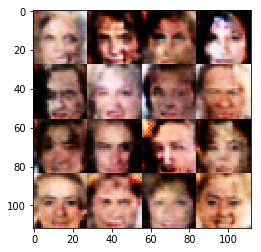

Epoch 1/1... Generator Loss: 1.1194 Discriminator Loss: 0.8049...
Epoch 1/1... Generator Loss: 1.6674 Discriminator Loss: 0.6342...
Epoch 1/1... Generator Loss: 2.2642 Discriminator Loss: 1.6583...
Epoch 1/1... Generator Loss: 1.0386 Discriminator Loss: 0.8808...
Epoch 1/1... Generator Loss: 1.2237 Discriminator Loss: 1.3175...
Epoch 1/1... Generator Loss: 2.7071 Discriminator Loss: 0.5327...
Epoch 1/1... Generator Loss: 0.5230 Discriminator Loss: 1.3216...
Epoch 1/1... Generator Loss: 2.0554 Discriminator Loss: 0.7020...
Epoch 1/1... Generator Loss: 2.6385 Discriminator Loss: 1.2786...
Epoch 1/1... Generator Loss: 1.7322 Discriminator Loss: 0.5757...


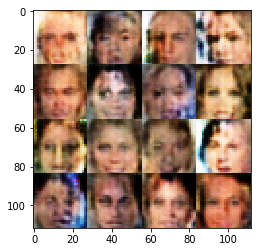

Epoch 1/1... Generator Loss: 0.5790 Discriminator Loss: 1.2601...
Epoch 1/1... Generator Loss: 2.1713 Discriminator Loss: 0.5484...
Epoch 1/1... Generator Loss: 1.8900 Discriminator Loss: 0.9668...
Epoch 1/1... Generator Loss: 2.8788 Discriminator Loss: 1.4976...
Epoch 1/1... Generator Loss: 1.9806 Discriminator Loss: 0.5629...
Epoch 1/1... Generator Loss: 1.1603 Discriminator Loss: 0.8220...
Epoch 1/1... Generator Loss: 1.9199 Discriminator Loss: 0.6082...
Epoch 1/1... Generator Loss: 2.2938 Discriminator Loss: 0.5572...
Epoch 1/1... Generator Loss: 0.8990 Discriminator Loss: 0.9567...
Epoch 1/1... Generator Loss: 2.5313 Discriminator Loss: 0.4573...


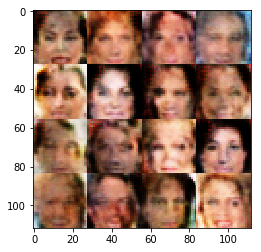

Epoch 1/1... Generator Loss: 2.9393 Discriminator Loss: 1.1795...
Epoch 1/1... Generator Loss: 1.0532 Discriminator Loss: 1.0346...
Epoch 1/1... Generator Loss: 1.2257 Discriminator Loss: 1.2941...
Epoch 1/1... Generator Loss: 2.4558 Discriminator Loss: 0.9362...
Epoch 1/1... Generator Loss: 2.6283 Discriminator Loss: 0.5449...
Epoch 1/1... Generator Loss: 0.8895 Discriminator Loss: 1.2940...
Epoch 1/1... Generator Loss: 1.5705 Discriminator Loss: 0.8688...
Epoch 1/1... Generator Loss: 1.3873 Discriminator Loss: 0.6799...
Epoch 1/1... Generator Loss: 1.1116 Discriminator Loss: 1.0818...
Epoch 1/1... Generator Loss: 2.4416 Discriminator Loss: 0.5083...


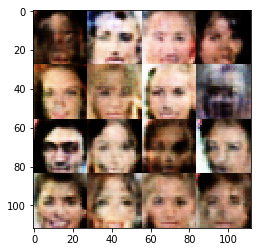

Epoch 1/1... Generator Loss: 2.2275 Discriminator Loss: 0.8428...
Epoch 1/1... Generator Loss: 1.0286 Discriminator Loss: 1.0649...
Epoch 1/1... Generator Loss: 2.6018 Discriminator Loss: 0.6939...
Epoch 1/1... Generator Loss: 2.8012 Discriminator Loss: 0.7247...
Epoch 1/1... Generator Loss: 0.8950 Discriminator Loss: 0.9364...
Epoch 1/1... Generator Loss: 1.4506 Discriminator Loss: 0.7135...
Epoch 1/1... Generator Loss: 0.3282 Discriminator Loss: 1.6988...
Epoch 1/1... Generator Loss: 1.9171 Discriminator Loss: 0.5752...
Epoch 1/1... Generator Loss: 1.7249 Discriminator Loss: 0.6429...
Epoch 1/1... Generator Loss: 1.6329 Discriminator Loss: 1.4982...


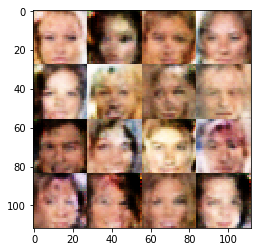

Epoch 1/1... Generator Loss: 0.9865 Discriminator Loss: 0.9179...
Epoch 1/1... Generator Loss: 0.6813 Discriminator Loss: 1.1219...
Epoch 1/1... Generator Loss: 0.6876 Discriminator Loss: 1.1291...
Epoch 1/1... Generator Loss: 2.3102 Discriminator Loss: 0.6688...
Epoch 1/1... Generator Loss: 0.6038 Discriminator Loss: 1.2324...
Epoch 1/1... Generator Loss: 0.6822 Discriminator Loss: 1.1595...
Epoch 1/1... Generator Loss: 0.8093 Discriminator Loss: 0.9916...
Epoch 1/1... Generator Loss: 3.0156 Discriminator Loss: 0.7917...
Epoch 1/1... Generator Loss: 2.4200 Discriminator Loss: 0.6200...
Epoch 1/1... Generator Loss: 1.2538 Discriminator Loss: 0.7426...


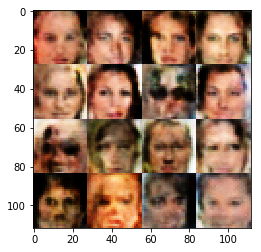

Epoch 1/1... Generator Loss: 1.1577 Discriminator Loss: 0.8879...
Epoch 1/1... Generator Loss: 1.8029 Discriminator Loss: 1.4688...
Epoch 1/1... Generator Loss: 1.3248 Discriminator Loss: 0.6830...
Epoch 1/1... Generator Loss: 1.2374 Discriminator Loss: 0.7936...
Epoch 1/1... Generator Loss: 0.3624 Discriminator Loss: 1.6362...
Epoch 1/1... Generator Loss: 1.6980 Discriminator Loss: 0.5604...
Epoch 1/1... Generator Loss: 2.4139 Discriminator Loss: 0.5283...
Epoch 1/1... Generator Loss: 1.2998 Discriminator Loss: 0.9039...
Epoch 1/1... Generator Loss: 1.8225 Discriminator Loss: 1.0590...
Epoch 1/1... Generator Loss: 1.7800 Discriminator Loss: 0.6306...


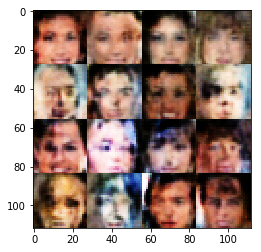

Epoch 1/1... Generator Loss: 2.1845 Discriminator Loss: 0.5608...
Epoch 1/1... Generator Loss: 1.6300 Discriminator Loss: 0.7234...
Epoch 1/1... Generator Loss: 2.8413 Discriminator Loss: 0.4881...
Epoch 1/1... Generator Loss: 0.2810 Discriminator Loss: 1.7957...
Epoch 1/1... Generator Loss: 0.9034 Discriminator Loss: 0.9154...
Epoch 1/1... Generator Loss: 1.9398 Discriminator Loss: 0.6356...
Epoch 1/1... Generator Loss: 2.3695 Discriminator Loss: 2.0225...
Epoch 1/1... Generator Loss: 3.0358 Discriminator Loss: 0.5647...
Epoch 1/1... Generator Loss: 1.1720 Discriminator Loss: 0.8086...
Epoch 1/1... Generator Loss: 0.7991 Discriminator Loss: 1.0249...


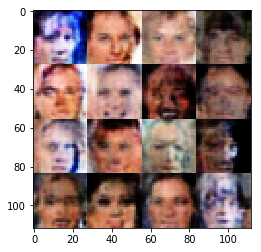

Epoch 1/1... Generator Loss: 1.6900 Discriminator Loss: 0.5761...
Epoch 1/1... Generator Loss: 0.3356 Discriminator Loss: 1.6926...
Epoch 1/1... Generator Loss: 2.1677 Discriminator Loss: 0.6599...
Epoch 1/1... Generator Loss: 1.7943 Discriminator Loss: 0.5541...
Epoch 1/1... Generator Loss: 0.8248 Discriminator Loss: 1.1755...
Epoch 1/1... Generator Loss: 2.7977 Discriminator Loss: 0.7914...
Epoch 1/1... Generator Loss: 2.8405 Discriminator Loss: 1.1332...
Epoch 1/1... Generator Loss: 1.2765 Discriminator Loss: 0.8097...
Epoch 1/1... Generator Loss: 0.3302 Discriminator Loss: 1.6593...
Epoch 1/1... Generator Loss: 1.8827 Discriminator Loss: 0.6197...


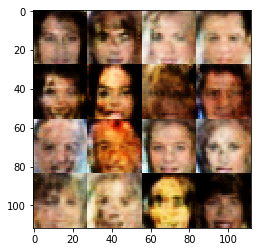

Epoch 1/1... Generator Loss: 0.8431 Discriminator Loss: 1.0235...
Epoch 1/1... Generator Loss: 3.2716 Discriminator Loss: 1.1935...
Epoch 1/1... Generator Loss: 0.9299 Discriminator Loss: 1.0919...
Epoch 1/1... Generator Loss: 2.2548 Discriminator Loss: 1.0110...
Epoch 1/1... Generator Loss: 0.3356 Discriminator Loss: 1.6975...
Epoch 1/1... Generator Loss: 3.2267 Discriminator Loss: 0.4654...
Epoch 1/1... Generator Loss: 0.7393 Discriminator Loss: 1.0458...
Epoch 1/1... Generator Loss: 1.7817 Discriminator Loss: 0.5995...
Epoch 1/1... Generator Loss: 2.0987 Discriminator Loss: 0.4996...
Epoch 1/1... Generator Loss: 1.8887 Discriminator Loss: 1.0424...


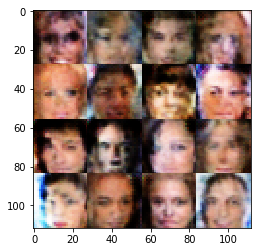

Epoch 1/1... Generator Loss: 0.2116 Discriminator Loss: 2.1079...
Epoch 1/1... Generator Loss: 1.4227 Discriminator Loss: 0.8138...
Epoch 1/1... Generator Loss: 0.2624 Discriminator Loss: 1.8820...
Epoch 1/1... Generator Loss: 1.8202 Discriminator Loss: 0.6231...
Epoch 1/1... Generator Loss: 1.9627 Discriminator Loss: 0.6286...
Epoch 1/1... Generator Loss: 2.3300 Discriminator Loss: 0.8844...
Epoch 1/1... Generator Loss: 0.6976 Discriminator Loss: 1.1240...
Epoch 1/1... Generator Loss: 1.9756 Discriminator Loss: 0.8252...
Epoch 1/1... Generator Loss: 1.8218 Discriminator Loss: 0.9588...
Epoch 1/1... Generator Loss: 1.5636 Discriminator Loss: 0.6545...


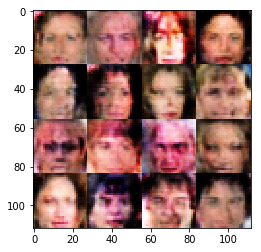

Epoch 1/1... Generator Loss: 1.5862 Discriminator Loss: 1.1555...
Epoch 1/1... Generator Loss: 0.4413 Discriminator Loss: 1.4324...
Epoch 1/1... Generator Loss: 1.8918 Discriminator Loss: 0.5824...
Epoch 1/1... Generator Loss: 2.0856 Discriminator Loss: 0.5077...
Epoch 1/1... Generator Loss: 2.4656 Discriminator Loss: 0.4465...
Epoch 1/1... Generator Loss: 0.8239 Discriminator Loss: 0.9862...
Epoch 1/1... Generator Loss: 1.0452 Discriminator Loss: 0.9183...
Epoch 1/1... Generator Loss: 0.7253 Discriminator Loss: 1.1046...
Epoch 1/1... Generator Loss: 2.5137 Discriminator Loss: 0.5883...
Epoch 1/1... Generator Loss: 1.7874 Discriminator Loss: 0.5869...


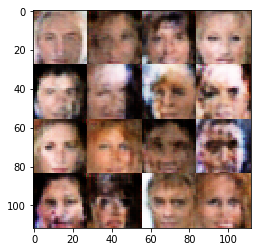

Epoch 1/1... Generator Loss: 1.1725 Discriminator Loss: 0.8609...
Epoch 1/1... Generator Loss: 1.7611 Discriminator Loss: 0.5915...
Epoch 1/1... Generator Loss: 0.5916 Discriminator Loss: 1.2764...
Epoch 1/1... Generator Loss: 1.5598 Discriminator Loss: 0.6497...
Epoch 1/1... Generator Loss: 1.6242 Discriminator Loss: 0.6539...
Epoch 1/1... Generator Loss: 1.0043 Discriminator Loss: 0.9610...
Epoch 1/1... Generator Loss: 2.1923 Discriminator Loss: 0.5332...
Epoch 1/1... Generator Loss: 0.8439 Discriminator Loss: 1.0967...
Epoch 1/1... Generator Loss: 1.1266 Discriminator Loss: 1.2554...
Epoch 1/1... Generator Loss: 2.7308 Discriminator Loss: 1.0668...


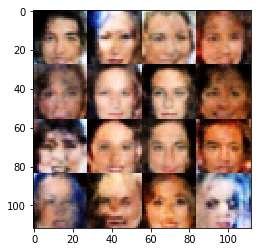

Epoch 1/1... Generator Loss: 2.1081 Discriminator Loss: 0.6295...
Epoch 1/1... Generator Loss: 1.7320 Discriminator Loss: 0.6157...
Epoch 1/1... Generator Loss: 1.7846 Discriminator Loss: 0.5823...
Epoch 1/1... Generator Loss: 2.4082 Discriminator Loss: 0.8253...
Epoch 1/1... Generator Loss: 1.1899 Discriminator Loss: 0.8139...
Epoch 1/1... Generator Loss: 1.4157 Discriminator Loss: 0.7060...
Epoch 1/1... Generator Loss: 0.6838 Discriminator Loss: 1.1621...
Epoch 1/1... Generator Loss: 2.2244 Discriminator Loss: 0.8200...
Epoch 1/1... Generator Loss: 0.6412 Discriminator Loss: 1.1968...
Epoch 1/1... Generator Loss: 0.5731 Discriminator Loss: 1.2535...


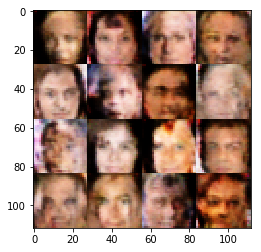

Epoch 1/1... Generator Loss: 2.8925 Discriminator Loss: 1.5761...
Epoch 1/1... Generator Loss: 1.1766 Discriminator Loss: 0.7404...
Epoch 1/1... Generator Loss: 1.1334 Discriminator Loss: 0.7771...
Epoch 1/1... Generator Loss: 4.9440 Discriminator Loss: 0.6060...
Epoch 1/1... Generator Loss: 3.4914 Discriminator Loss: 0.4060...
Epoch 1/1... Generator Loss: 4.8654 Discriminator Loss: 0.3494...
Epoch 1/1... Generator Loss: 3.8739 Discriminator Loss: 0.3681...
Epoch 1/1... Generator Loss: 3.4848 Discriminator Loss: 0.3791...
Epoch 1/1... Generator Loss: 3.9782 Discriminator Loss: 0.7493...
Epoch 1/1... Generator Loss: 4.2519 Discriminator Loss: 3.6018...


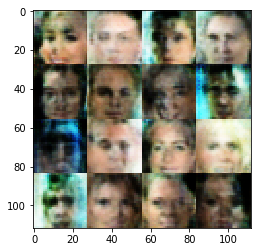

Epoch 1/1... Generator Loss: 0.9076 Discriminator Loss: 0.9023...
Epoch 1/1... Generator Loss: 1.2342 Discriminator Loss: 0.7661...
Epoch 1/1... Generator Loss: 4.5158 Discriminator Loss: 0.4015...
Epoch 1/1... Generator Loss: 1.1564 Discriminator Loss: 0.8082...
Epoch 1/1... Generator Loss: 0.6151 Discriminator Loss: 1.3044...
Epoch 1/1... Generator Loss: 2.1074 Discriminator Loss: 0.8891...
Epoch 1/1... Generator Loss: 3.3242 Discriminator Loss: 0.5512...
Epoch 1/1... Generator Loss: 2.9293 Discriminator Loss: 0.6795...
Epoch 1/1... Generator Loss: 1.4250 Discriminator Loss: 1.4185...
Epoch 1/1... Generator Loss: 0.7101 Discriminator Loss: 1.0652...


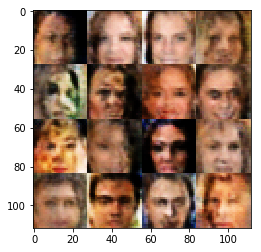

Epoch 1/1... Generator Loss: 1.4511 Discriminator Loss: 0.7224...
Epoch 1/1... Generator Loss: 1.3755 Discriminator Loss: 0.6928...
Epoch 1/1... Generator Loss: 3.8996 Discriminator Loss: 0.6476...
Epoch 1/1... Generator Loss: 1.6534 Discriminator Loss: 1.2611...
Epoch 1/1... Generator Loss: 0.8065 Discriminator Loss: 1.0255...
Epoch 1/1... Generator Loss: 0.4052 Discriminator Loss: 1.5039...
Epoch 1/1... Generator Loss: 0.3696 Discriminator Loss: 1.5934...
Epoch 1/1... Generator Loss: 2.5752 Discriminator Loss: 2.0714...
Epoch 1/1... Generator Loss: 1.0341 Discriminator Loss: 0.9857...
Epoch 1/1... Generator Loss: 1.7475 Discriminator Loss: 0.7077...


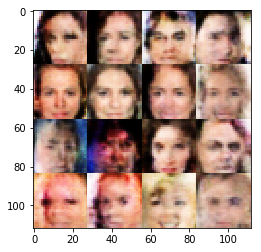

Epoch 1/1... Generator Loss: 1.8322 Discriminator Loss: 1.9511...
Epoch 1/1... Generator Loss: 2.6115 Discriminator Loss: 0.6526...
Epoch 1/1... Generator Loss: 0.9716 Discriminator Loss: 1.0547...
Epoch 1/1... Generator Loss: 0.7020 Discriminator Loss: 1.2938...
Epoch 1/1... Generator Loss: 1.9959 Discriminator Loss: 0.5808...
Epoch 1/1... Generator Loss: 1.3455 Discriminator Loss: 0.8117...
Epoch 1/1... Generator Loss: 0.5442 Discriminator Loss: 1.2808...
Epoch 1/1... Generator Loss: 1.2132 Discriminator Loss: 0.7934...
Epoch 1/1... Generator Loss: 0.4416 Discriminator Loss: 1.4302...
Epoch 1/1... Generator Loss: 1.7739 Discriminator Loss: 0.5700...


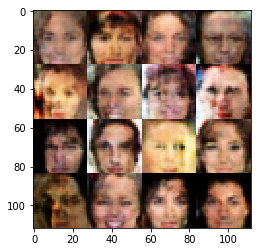

Epoch 1/1... Generator Loss: 1.2207 Discriminator Loss: 0.7663...
Epoch 1/1... Generator Loss: 1.3943 Discriminator Loss: 0.9455...
Epoch 1/1... Generator Loss: 0.9148 Discriminator Loss: 0.9095...
Epoch 1/1... Generator Loss: 1.6461 Discriminator Loss: 0.9042...
Epoch 1/1... Generator Loss: 2.2102 Discriminator Loss: 0.4778...
Epoch 1/1... Generator Loss: 1.2729 Discriminator Loss: 0.7485...
Epoch 1/1... Generator Loss: 0.2549 Discriminator Loss: 1.9287...
Epoch 1/1... Generator Loss: 2.0976 Discriminator Loss: 0.9135...
Epoch 1/1... Generator Loss: 0.9147 Discriminator Loss: 0.8948...
Epoch 1/1... Generator Loss: 1.4333 Discriminator Loss: 0.6390...


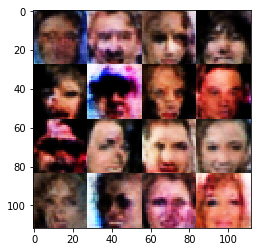

Epoch 1/1... Generator Loss: 1.6077 Discriminator Loss: 0.7004...
Epoch 1/1... Generator Loss: 0.6098 Discriminator Loss: 1.2071...
Epoch 1/1... Generator Loss: 2.0470 Discriminator Loss: 0.5513...
Epoch 1/1... Generator Loss: 0.5635 Discriminator Loss: 1.2606...
Epoch 1/1... Generator Loss: 1.2269 Discriminator Loss: 0.8209...
Epoch 1/1... Generator Loss: 0.7696 Discriminator Loss: 1.0602...
Epoch 1/1... Generator Loss: 0.6579 Discriminator Loss: 1.1682...
Epoch 1/1... Generator Loss: 1.2675 Discriminator Loss: 0.6964...
Epoch 1/1... Generator Loss: 1.4903 Discriminator Loss: 0.6357...
Epoch 1/1... Generator Loss: 0.4417 Discriminator Loss: 1.4186...


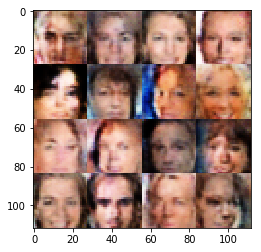

Epoch 1/1... Generator Loss: 3.2382 Discriminator Loss: 1.0943...
Epoch 1/1... Generator Loss: 2.0757 Discriminator Loss: 0.5064...
Epoch 1/1... Generator Loss: 0.5865 Discriminator Loss: 1.2540...
Epoch 1/1... Generator Loss: 2.1101 Discriminator Loss: 1.7240...
Epoch 1/1... Generator Loss: 1.3247 Discriminator Loss: 1.0104...
Epoch 1/1... Generator Loss: 0.8132 Discriminator Loss: 0.9906...
Epoch 1/1... Generator Loss: 0.7647 Discriminator Loss: 1.1265...
Epoch 1/1... Generator Loss: 0.9998 Discriminator Loss: 1.0401...
Epoch 1/1... Generator Loss: 1.9300 Discriminator Loss: 1.4411...
Epoch 1/1... Generator Loss: 1.5584 Discriminator Loss: 0.6095...


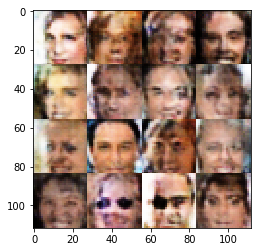

Epoch 1/1... Generator Loss: 1.2080 Discriminator Loss: 0.8285...
Epoch 1/1... Generator Loss: 1.0624 Discriminator Loss: 0.8607...
Epoch 1/1... Generator Loss: 0.7718 Discriminator Loss: 1.0685...
Epoch 1/1... Generator Loss: 1.7116 Discriminator Loss: 0.9911...
Epoch 1/1... Generator Loss: 0.4224 Discriminator Loss: 1.4965...
Epoch 1/1... Generator Loss: 1.5903 Discriminator Loss: 1.6003...
Epoch 1/1... Generator Loss: 2.1819 Discriminator Loss: 0.7742...
Epoch 1/1... Generator Loss: 0.8494 Discriminator Loss: 1.0178...
Epoch 1/1... Generator Loss: 1.6151 Discriminator Loss: 1.0396...
Epoch 1/1... Generator Loss: 0.2412 Discriminator Loss: 1.9787...


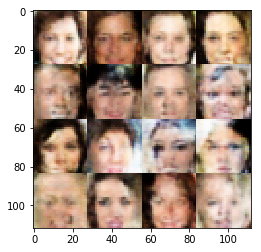

Epoch 1/1... Generator Loss: 0.7698 Discriminator Loss: 1.0708...
Epoch 1/1... Generator Loss: 1.1034 Discriminator Loss: 0.8191...
Epoch 1/1... Generator Loss: 1.3467 Discriminator Loss: 0.7055...
Epoch 1/1... Generator Loss: 2.8660 Discriminator Loss: 1.8761...
Epoch 1/1... Generator Loss: 1.5380 Discriminator Loss: 0.8366...
Epoch 1/1... Generator Loss: 2.0127 Discriminator Loss: 1.6616...
Epoch 1/1... Generator Loss: 1.9734 Discriminator Loss: 0.5416...
Epoch 1/1... Generator Loss: 1.0581 Discriminator Loss: 0.9223...
Epoch 1/1... Generator Loss: 0.3367 Discriminator Loss: 1.6319...
Epoch 1/1... Generator Loss: 1.4220 Discriminator Loss: 1.6444...


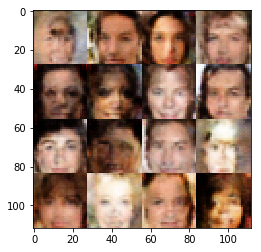

Epoch 1/1... Generator Loss: 0.6912 Discriminator Loss: 1.2004...
Epoch 1/1... Generator Loss: 0.4946 Discriminator Loss: 1.3945...
Epoch 1/1... Generator Loss: 2.2388 Discriminator Loss: 0.4869...
Epoch 1/1... Generator Loss: 1.7053 Discriminator Loss: 0.5808...
Epoch 1/1... Generator Loss: 0.8380 Discriminator Loss: 1.2118...
Epoch 1/1... Generator Loss: 2.6425 Discriminator Loss: 0.4640...
Epoch 1/1... Generator Loss: 0.6893 Discriminator Loss: 1.5132...
Epoch 1/1... Generator Loss: 2.2880 Discriminator Loss: 0.6220...
Epoch 1/1... Generator Loss: 0.3654 Discriminator Loss: 1.5878...
Epoch 1/1... Generator Loss: 0.7891 Discriminator Loss: 1.0115...


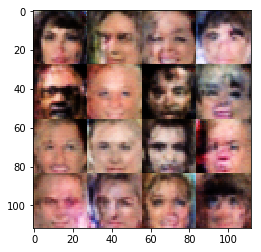

Epoch 1/1... Generator Loss: 0.3354 Discriminator Loss: 1.6475...
Epoch 1/1... Generator Loss: 1.3576 Discriminator Loss: 0.7983...
Epoch 1/1... Generator Loss: 1.8520 Discriminator Loss: 0.7616...
Epoch 1/1... Generator Loss: 0.1582 Discriminator Loss: 2.3497...
Epoch 1/1... Generator Loss: 1.0393 Discriminator Loss: 0.9513...
Epoch 1/1... Generator Loss: 0.6866 Discriminator Loss: 1.4399...
Epoch 1/1... Generator Loss: 1.5525 Discriminator Loss: 0.9169...
Epoch 1/1... Generator Loss: 2.0449 Discriminator Loss: 0.6492...
Epoch 1/1... Generator Loss: 0.8821 Discriminator Loss: 0.9254...
Epoch 1/1... Generator Loss: 1.6925 Discriminator Loss: 1.9654...


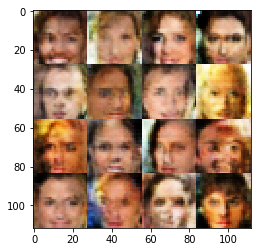

Epoch 1/1... Generator Loss: 1.5258 Discriminator Loss: 0.7410...
Epoch 1/1... Generator Loss: 3.2407 Discriminator Loss: 0.7853...
Epoch 1/1... Generator Loss: 0.2655 Discriminator Loss: 1.9523...
Epoch 1/1... Generator Loss: 0.5289 Discriminator Loss: 1.3459...
Epoch 1/1... Generator Loss: 1.0632 Discriminator Loss: 0.8329...
Epoch 1/1... Generator Loss: 0.9971 Discriminator Loss: 0.8871...
Epoch 1/1... Generator Loss: 0.9887 Discriminator Loss: 0.9388...
Epoch 1/1... Generator Loss: 1.4395 Discriminator Loss: 1.0049...
Epoch 1/1... Generator Loss: 0.4585 Discriminator Loss: 1.5564...
Epoch 1/1... Generator Loss: 1.2249 Discriminator Loss: 1.1320...


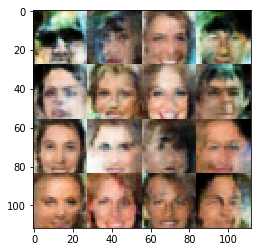

Epoch 1/1... Generator Loss: 0.4038 Discriminator Loss: 1.5976...
Epoch 1/1... Generator Loss: 0.8996 Discriminator Loss: 1.0890...
Epoch 1/1... Generator Loss: 1.8051 Discriminator Loss: 0.6299...
Epoch 1/1... Generator Loss: 0.6910 Discriminator Loss: 1.1605...
Epoch 1/1... Generator Loss: 2.3800 Discriminator Loss: 0.5170...
Epoch 1/1... Generator Loss: 0.6455 Discriminator Loss: 1.1427...
Epoch 1/1... Generator Loss: 1.6598 Discriminator Loss: 0.6218...
Epoch 1/1... Generator Loss: 0.4094 Discriminator Loss: 1.4928...
Epoch 1/1... Generator Loss: 1.8510 Discriminator Loss: 0.5592...
Epoch 1/1... Generator Loss: 0.6379 Discriminator Loss: 1.1724...


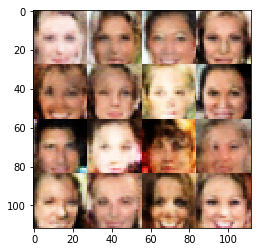

Epoch 1/1... Generator Loss: 1.5099 Discriminator Loss: 1.1656...
Epoch 1/1... Generator Loss: 2.1587 Discriminator Loss: 0.5419...
Epoch 1/1... Generator Loss: 0.9480 Discriminator Loss: 1.3788...
Epoch 1/1... Generator Loss: 0.3964 Discriminator Loss: 1.5608...
Epoch 1/1... Generator Loss: 1.6179 Discriminator Loss: 0.8680...
Epoch 1/1... Generator Loss: 0.6051 Discriminator Loss: 1.2598...
Epoch 1/1... Generator Loss: 0.9151 Discriminator Loss: 0.8795...
Epoch 1/1... Generator Loss: 0.5598 Discriminator Loss: 1.2660...
Epoch 1/1... Generator Loss: 0.4713 Discriminator Loss: 1.4301...
Epoch 1/1... Generator Loss: 0.7498 Discriminator Loss: 1.0609...


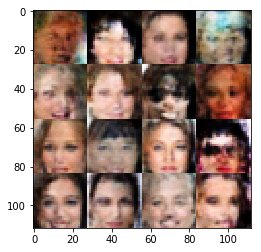

Epoch 1/1... Generator Loss: 1.2375 Discriminator Loss: 0.9176...
Epoch 1/1... Generator Loss: 0.5363 Discriminator Loss: 1.2918...
Epoch 1/1... Generator Loss: 1.1474 Discriminator Loss: 0.7759...
Epoch 1/1... Generator Loss: 0.5657 Discriminator Loss: 1.3231...
Epoch 1/1... Generator Loss: 1.6104 Discriminator Loss: 0.5714...
Epoch 1/1... Generator Loss: 1.4343 Discriminator Loss: 0.7341...
Epoch 1/1... Generator Loss: 0.6203 Discriminator Loss: 1.1814...
Epoch 1/1... Generator Loss: 0.5529 Discriminator Loss: 1.2561...
Epoch 1/1... Generator Loss: 1.5963 Discriminator Loss: 1.0873...
Epoch 1/1... Generator Loss: 0.6320 Discriminator Loss: 1.1609...


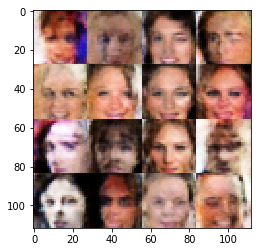

Epoch 1/1... Generator Loss: 1.8239 Discriminator Loss: 1.6500...
Epoch 1/1... Generator Loss: 2.3856 Discriminator Loss: 0.4841...
Epoch 1/1... Generator Loss: 2.4398 Discriminator Loss: 0.4586...
Epoch 1/1... Generator Loss: 1.0893 Discriminator Loss: 0.8171...
Epoch 1/1... Generator Loss: 0.6958 Discriminator Loss: 1.1031...
Epoch 1/1... Generator Loss: 1.4778 Discriminator Loss: 1.1787...
Epoch 1/1... Generator Loss: 2.3198 Discriminator Loss: 0.8238...
Epoch 1/1... Generator Loss: 1.3776 Discriminator Loss: 0.6652...
Epoch 1/1... Generator Loss: 2.5124 Discriminator Loss: 1.9500...
Epoch 1/1... Generator Loss: 1.0267 Discriminator Loss: 1.1517...


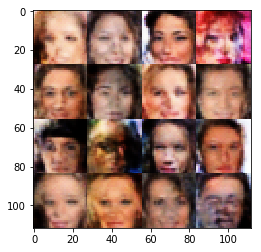

Epoch 1/1... Generator Loss: 2.6013 Discriminator Loss: 2.1091...
Epoch 1/1... Generator Loss: 1.3638 Discriminator Loss: 0.6988...
Epoch 1/1... Generator Loss: 2.8187 Discriminator Loss: 0.4117...
Epoch 1/1... Generator Loss: 1.7441 Discriminator Loss: 1.2086...
Epoch 1/1... Generator Loss: 1.1289 Discriminator Loss: 0.9408...
Epoch 1/1... Generator Loss: 1.0348 Discriminator Loss: 1.1141...
Epoch 1/1... Generator Loss: 2.2898 Discriminator Loss: 0.7506...
Epoch 1/1... Generator Loss: 0.8762 Discriminator Loss: 0.9834...
Epoch 1/1... Generator Loss: 0.6485 Discriminator Loss: 1.2399...
Epoch 1/1... Generator Loss: 0.4805 Discriminator Loss: 1.3853...


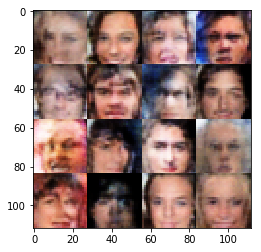

Epoch 1/1... Generator Loss: 1.0647 Discriminator Loss: 0.9903...
Epoch 1/1... Generator Loss: 1.5964 Discriminator Loss: 0.7111...
Epoch 1/1... Generator Loss: 0.4911 Discriminator Loss: 1.5764...
Epoch 1/1... Generator Loss: 0.5397 Discriminator Loss: 1.3287...
Epoch 1/1... Generator Loss: 1.7035 Discriminator Loss: 0.5798...
Epoch 1/1... Generator Loss: 0.7726 Discriminator Loss: 1.0520...
Epoch 1/1... Generator Loss: 1.9013 Discriminator Loss: 1.1839...
Epoch 1/1... Generator Loss: 1.9769 Discriminator Loss: 0.6130...
Epoch 1/1... Generator Loss: 2.7430 Discriminator Loss: 2.0797...
Epoch 1/1... Generator Loss: 0.8319 Discriminator Loss: 1.0089...


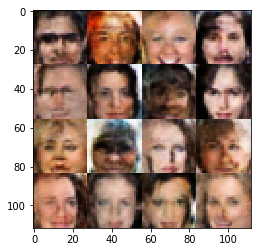

Epoch 1/1... Generator Loss: 1.5513 Discriminator Loss: 0.6403...
Epoch 1/1... Generator Loss: 0.8112 Discriminator Loss: 1.0235...
Epoch 1/1... Generator Loss: 0.5944 Discriminator Loss: 1.2294...
Epoch 1/1... Generator Loss: 0.9760 Discriminator Loss: 0.9467...
Epoch 1/1... Generator Loss: 1.1313 Discriminator Loss: 0.8311...
Epoch 1/1... Generator Loss: 0.4644 Discriminator Loss: 1.4083...
Epoch 1/1... Generator Loss: 0.7510 Discriminator Loss: 1.0221...
Epoch 1/1... Generator Loss: 0.9712 Discriminator Loss: 0.8660...
Epoch 1/1... Generator Loss: 2.5046 Discriminator Loss: 1.9982...
Epoch 1/1... Generator Loss: 0.5421 Discriminator Loss: 1.2925...


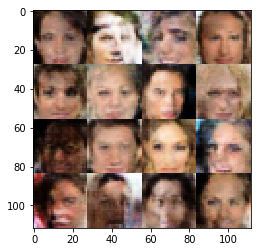

Epoch 1/1... Generator Loss: 0.9298 Discriminator Loss: 0.8983...
Epoch 1/1... Generator Loss: 1.1720 Discriminator Loss: 1.1725...
Epoch 1/1... Generator Loss: 0.8063 Discriminator Loss: 1.0640...
Epoch 1/1... Generator Loss: 1.6914 Discriminator Loss: 1.1274...
Epoch 1/1... Generator Loss: 2.1348 Discriminator Loss: 0.6054...
Epoch 1/1... Generator Loss: 1.3211 Discriminator Loss: 0.9483...
Epoch 1/1... Generator Loss: 0.6433 Discriminator Loss: 1.2807...
Epoch 1/1... Generator Loss: 0.4625 Discriminator Loss: 1.5510...
Epoch 1/1... Generator Loss: 0.5601 Discriminator Loss: 1.4783...
Epoch 1/1... Generator Loss: 1.7914 Discriminator Loss: 0.5867...


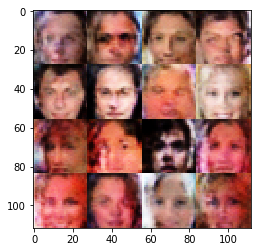

Epoch 1/1... Generator Loss: 1.4387 Discriminator Loss: 1.3982...
Epoch 1/1... Generator Loss: 0.7373 Discriminator Loss: 1.1277...
Epoch 1/1... Generator Loss: 1.8230 Discriminator Loss: 0.5663...
Epoch 1/1... Generator Loss: 0.9226 Discriminator Loss: 0.9052...
Epoch 1/1... Generator Loss: 1.2769 Discriminator Loss: 0.7007...
Epoch 1/1... Generator Loss: 0.2581 Discriminator Loss: 1.8941...
Epoch 1/1... Generator Loss: 1.0430 Discriminator Loss: 0.8534...
Epoch 1/1... Generator Loss: 2.2608 Discriminator Loss: 0.5264...
Epoch 1/1... Generator Loss: 0.7515 Discriminator Loss: 1.0655...
Epoch 1/1... Generator Loss: 0.8364 Discriminator Loss: 0.9435...


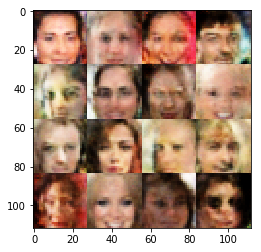

Epoch 1/1... Generator Loss: 2.5733 Discriminator Loss: 0.8516...
Epoch 1/1... Generator Loss: 1.2378 Discriminator Loss: 0.7581...
Epoch 1/1... Generator Loss: 3.3482 Discriminator Loss: 0.4527...
Epoch 1/1... Generator Loss: 1.0856 Discriminator Loss: 0.8421...
Epoch 1/1... Generator Loss: 0.4586 Discriminator Loss: 1.4223...
Epoch 1/1... Generator Loss: 1.3876 Discriminator Loss: 0.7192...
Epoch 1/1... Generator Loss: 3.3986 Discriminator Loss: 0.4197...
Epoch 1/1... Generator Loss: 3.5860 Discriminator Loss: 0.5117...
Epoch 1/1... Generator Loss: 1.2912 Discriminator Loss: 1.0295...
Epoch 1/1... Generator Loss: 1.8322 Discriminator Loss: 1.1256...


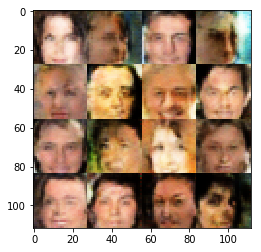

Epoch 1/1... Generator Loss: 0.3292 Discriminator Loss: 1.7159...
Epoch 1/1... Generator Loss: 1.4385 Discriminator Loss: 0.6913...
Epoch 1/1... Generator Loss: 1.4577 Discriminator Loss: 0.6906...
Epoch 1/1... Generator Loss: 0.5412 Discriminator Loss: 1.3854...
Epoch 1/1... Generator Loss: 0.9806 Discriminator Loss: 1.0868...
Epoch 1/1... Generator Loss: 0.9332 Discriminator Loss: 0.8599...
Epoch 1/1... Generator Loss: 0.5589 Discriminator Loss: 1.2677...
Epoch 1/1... Generator Loss: 1.8787 Discriminator Loss: 1.9869...
Epoch 1/1... Generator Loss: 1.6416 Discriminator Loss: 1.4603...
Epoch 1/1... Generator Loss: 1.9657 Discriminator Loss: 1.2736...


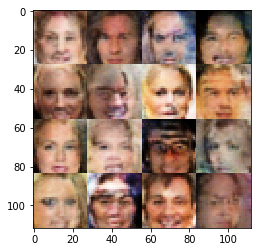

Epoch 1/1... Generator Loss: 1.5821 Discriminator Loss: 0.6902...
Epoch 1/1... Generator Loss: 1.7903 Discriminator Loss: 0.5610...
Epoch 1/1... Generator Loss: 1.3656 Discriminator Loss: 0.6916...
Epoch 1/1... Generator Loss: 3.0810 Discriminator Loss: 0.4147...
Epoch 1/1... Generator Loss: 1.5764 Discriminator Loss: 1.5450...
Epoch 1/1... Generator Loss: 1.5062 Discriminator Loss: 1.3809...
Epoch 1/1... Generator Loss: 2.9728 Discriminator Loss: 0.7860...
Epoch 1/1... Generator Loss: 1.5712 Discriminator Loss: 0.6104...
Epoch 1/1... Generator Loss: 1.3404 Discriminator Loss: 1.1779...
Epoch 1/1... Generator Loss: 0.8398 Discriminator Loss: 1.1989...


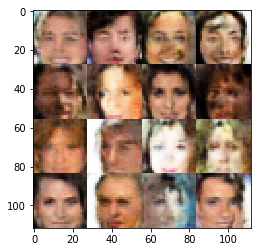

Epoch 1/1... Generator Loss: 1.3155 Discriminator Loss: 0.7284...
Epoch 1/1... Generator Loss: 0.4975 Discriminator Loss: 1.3704...
Epoch 1/1... Generator Loss: 3.1096 Discriminator Loss: 0.9704...
Epoch 1/1... Generator Loss: 3.2241 Discriminator Loss: 0.4210...
Epoch 1/1... Generator Loss: 2.5391 Discriminator Loss: 0.5554...
Epoch 1/1... Generator Loss: 1.0531 Discriminator Loss: 0.8013...
Epoch 1/1... Generator Loss: 2.1142 Discriminator Loss: 0.5476...
Epoch 1/1... Generator Loss: 0.4632 Discriminator Loss: 1.4304...
Epoch 1/1... Generator Loss: 2.5240 Discriminator Loss: 0.9621...
Epoch 1/1... Generator Loss: 2.9402 Discriminator Loss: 0.6249...


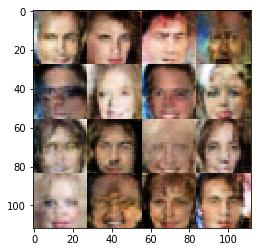

Epoch 1/1... Generator Loss: 2.8469 Discriminator Loss: 0.6408...
Epoch 1/1... Generator Loss: 0.4382 Discriminator Loss: 1.5217...
Epoch 1/1... Generator Loss: 0.8524 Discriminator Loss: 1.2839...
Epoch 1/1... Generator Loss: 0.8584 Discriminator Loss: 0.9461...
Epoch 1/1... Generator Loss: 1.3372 Discriminator Loss: 0.6846...
Epoch 1/1... Generator Loss: 0.9668 Discriminator Loss: 0.9128...
Epoch 1/1... Generator Loss: 1.1653 Discriminator Loss: 0.9067...
Epoch 1/1... Generator Loss: 1.3517 Discriminator Loss: 1.1802...
Epoch 1/1... Generator Loss: 1.0527 Discriminator Loss: 0.8104...
Epoch 1/1... Generator Loss: 2.9384 Discriminator Loss: 0.6440...


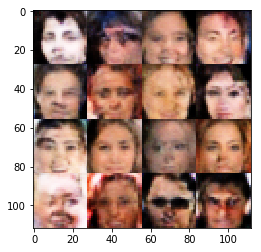

Epoch 1/1... Generator Loss: 1.0678 Discriminator Loss: 0.8525...
Epoch 1/1... Generator Loss: 1.8317 Discriminator Loss: 0.6244...
Epoch 1/1... Generator Loss: 1.1470 Discriminator Loss: 0.7884...
Epoch 1/1... Generator Loss: 0.4507 Discriminator Loss: 1.4732...
Epoch 1/1... Generator Loss: 0.4850 Discriminator Loss: 1.3940...
Epoch 1/1... Generator Loss: 3.4042 Discriminator Loss: 0.5435...
Epoch 1/1... Generator Loss: 1.1686 Discriminator Loss: 1.2183...
Epoch 1/1... Generator Loss: 0.6341 Discriminator Loss: 1.2298...
Epoch 1/1... Generator Loss: 0.6899 Discriminator Loss: 1.0700...
Epoch 1/1... Generator Loss: 0.7960 Discriminator Loss: 0.9767...


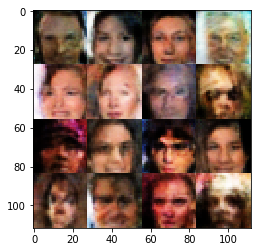

Epoch 1/1... Generator Loss: 1.8195 Discriminator Loss: 0.5826...
Epoch 1/1... Generator Loss: 1.0794 Discriminator Loss: 1.1256...
Epoch 1/1... Generator Loss: 1.8106 Discriminator Loss: 1.3943...
Epoch 1/1... Generator Loss: 1.1307 Discriminator Loss: 1.0641...
Epoch 1/1... Generator Loss: 1.6033 Discriminator Loss: 0.6026...
Epoch 1/1... Generator Loss: 2.7052 Discriminator Loss: 0.7194...
Epoch 1/1... Generator Loss: 3.5509 Discriminator Loss: 0.4862...
Epoch 1/1... Generator Loss: 0.9173 Discriminator Loss: 0.8870...
Epoch 1/1... Generator Loss: 0.7239 Discriminator Loss: 1.0284...
Epoch 1/1... Generator Loss: 1.5977 Discriminator Loss: 0.6821...


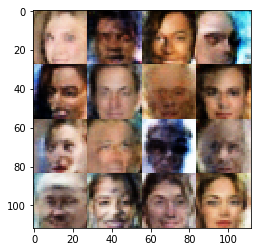

Epoch 1/1... Generator Loss: 2.3064 Discriminator Loss: 0.8140...
Epoch 1/1... Generator Loss: 0.6389 Discriminator Loss: 1.1500...
Epoch 1/1... Generator Loss: 1.2510 Discriminator Loss: 0.7715...
Epoch 1/1... Generator Loss: 1.4485 Discriminator Loss: 1.2473...
Epoch 1/1... Generator Loss: 1.2503 Discriminator Loss: 1.2324...
Epoch 1/1... Generator Loss: 0.1873 Discriminator Loss: 2.2547...
Epoch 1/1... Generator Loss: 1.3983 Discriminator Loss: 0.9569...
Epoch 1/1... Generator Loss: 0.2758 Discriminator Loss: 1.8666...
Epoch 1/1... Generator Loss: 0.8405 Discriminator Loss: 0.9445...
Epoch 1/1... Generator Loss: 2.2459 Discriminator Loss: 0.5279...


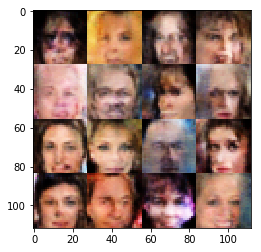

Epoch 1/1... Generator Loss: 1.6282 Discriminator Loss: 0.6752...
Epoch 1/1... Generator Loss: 0.6609 Discriminator Loss: 1.1141...
Epoch 1/1... Generator Loss: 0.2193 Discriminator Loss: 2.0733...
Epoch 1/1... Generator Loss: 2.4177 Discriminator Loss: 0.4565...
Epoch 1/1... Generator Loss: 2.0828 Discriminator Loss: 1.3481...
Epoch 1/1... Generator Loss: 1.3025 Discriminator Loss: 0.8115...
Epoch 1/1... Generator Loss: 1.3168 Discriminator Loss: 0.6870...
Epoch 1/1... Generator Loss: 0.8910 Discriminator Loss: 1.1405...
Epoch 1/1... Generator Loss: 1.8937 Discriminator Loss: 0.5517...
Epoch 1/1... Generator Loss: 0.5367 Discriminator Loss: 1.3460...


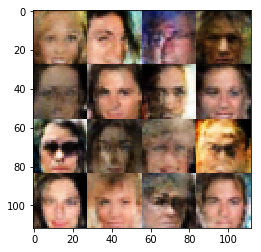

Epoch 1/1... Generator Loss: 1.2157 Discriminator Loss: 0.7742...
Epoch 1/1... Generator Loss: 0.4887 Discriminator Loss: 1.3829...
Epoch 1/1... Generator Loss: 0.9066 Discriminator Loss: 0.9062...
Epoch 1/1... Generator Loss: 2.6459 Discriminator Loss: 0.7065...
Epoch 1/1... Generator Loss: 1.5407 Discriminator Loss: 0.7956...
Epoch 1/1... Generator Loss: 1.7266 Discriminator Loss: 1.1550...
Epoch 1/1... Generator Loss: 1.9520 Discriminator Loss: 1.6354...
Epoch 1/1... Generator Loss: 1.5576 Discriminator Loss: 0.6469...
Epoch 1/1... Generator Loss: 2.2880 Discriminator Loss: 2.3609...
Epoch 1/1... Generator Loss: 0.7983 Discriminator Loss: 1.0039...


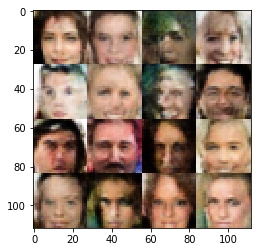

Epoch 1/1... Generator Loss: 1.6405 Discriminator Loss: 0.7297...
Epoch 1/1... Generator Loss: 1.1207 Discriminator Loss: 0.9105...
Epoch 1/1... Generator Loss: 0.9804 Discriminator Loss: 1.1530...
Epoch 1/1... Generator Loss: 1.4639 Discriminator Loss: 1.1925...
Epoch 1/1... Generator Loss: 0.8846 Discriminator Loss: 1.0482...
Epoch 1/1... Generator Loss: 0.5781 Discriminator Loss: 1.3005...
Epoch 1/1... Generator Loss: 0.4976 Discriminator Loss: 1.3331...
Epoch 1/1... Generator Loss: 3.0642 Discriminator Loss: 0.7361...
Epoch 1/1... Generator Loss: 3.3614 Discriminator Loss: 1.0221...
Epoch 1/1... Generator Loss: 0.5761 Discriminator Loss: 1.5366...


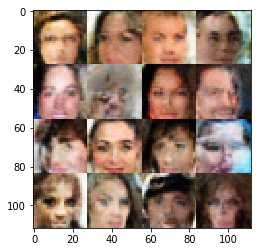

Epoch 1/1... Generator Loss: 0.7701 Discriminator Loss: 1.2726...
Epoch 1/1... Generator Loss: 0.8221 Discriminator Loss: 0.9903...
Epoch 1/1... Generator Loss: 2.8939 Discriminator Loss: 1.3878...
Epoch 1/1... Generator Loss: 2.2688 Discriminator Loss: 1.4431...
Epoch 1/1... Generator Loss: 0.4636 Discriminator Loss: 1.4369...
Epoch 1/1... Generator Loss: 1.5035 Discriminator Loss: 0.9454...
Epoch 1/1... Generator Loss: 1.5327 Discriminator Loss: 0.8783...
Epoch 1/1... Generator Loss: 1.4962 Discriminator Loss: 0.7735...
Epoch 1/1... Generator Loss: 1.3096 Discriminator Loss: 1.6925...
Epoch 1/1... Generator Loss: 1.5967 Discriminator Loss: 0.6306...


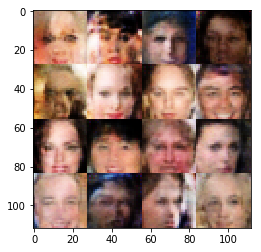

Epoch 1/1... Generator Loss: 2.0227 Discriminator Loss: 0.6325...
Epoch 1/1... Generator Loss: 1.1558 Discriminator Loss: 1.0271...
Epoch 1/1... Generator Loss: 1.8496 Discriminator Loss: 1.0125...
Epoch 1/1... Generator Loss: 1.2649 Discriminator Loss: 1.6279...
Epoch 1/1... Generator Loss: 1.7371 Discriminator Loss: 1.4864...
Epoch 1/1... Generator Loss: 0.8373 Discriminator Loss: 0.9529...
Epoch 1/1... Generator Loss: 0.3541 Discriminator Loss: 1.6086...
Epoch 1/1... Generator Loss: 3.7755 Discriminator Loss: 0.5371...
Epoch 1/1... Generator Loss: 0.4627 Discriminator Loss: 1.4144...
Epoch 1/1... Generator Loss: 0.5779 Discriminator Loss: 1.2439...


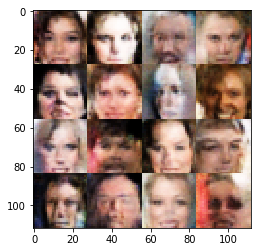

Epoch 1/1... Generator Loss: 0.7225 Discriminator Loss: 1.1551...
Epoch 1/1... Generator Loss: 1.6643 Discriminator Loss: 0.6759...
Epoch 1/1... Generator Loss: 1.4594 Discriminator Loss: 1.4997...
Epoch 1/1... Generator Loss: 0.9833 Discriminator Loss: 1.2525...
Epoch 1/1... Generator Loss: 0.5246 Discriminator Loss: 1.3066...
Epoch 1/1... Generator Loss: 1.6103 Discriminator Loss: 0.5944...
Epoch 1/1... Generator Loss: 1.2113 Discriminator Loss: 0.9168...
Epoch 1/1... Generator Loss: 0.4738 Discriminator Loss: 1.4164...
Epoch 1/1... Generator Loss: 2.3454 Discriminator Loss: 0.5017...
Epoch 1/1... Generator Loss: 0.8972 Discriminator Loss: 0.9128...


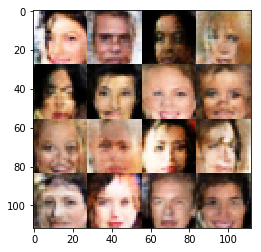

Epoch 1/1... Generator Loss: 1.4636 Discriminator Loss: 1.6797...
Epoch 1/1... Generator Loss: 1.8925 Discriminator Loss: 0.5549...
Epoch 1/1... Generator Loss: 1.1553 Discriminator Loss: 0.7703...
Epoch 1/1... Generator Loss: 2.3068 Discriminator Loss: 0.7916...
Epoch 1/1... Generator Loss: 0.5147 Discriminator Loss: 1.3665...
Epoch 1/1... Generator Loss: 1.2599 Discriminator Loss: 0.6969...
Epoch 1/1... Generator Loss: 1.4643 Discriminator Loss: 0.6789...
Epoch 1/1... Generator Loss: 1.1123 Discriminator Loss: 1.2392...
Epoch 1/1... Generator Loss: 1.1321 Discriminator Loss: 0.8636...
Epoch 1/1... Generator Loss: 1.9495 Discriminator Loss: 0.7411...


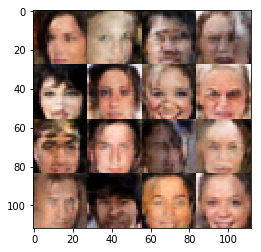

Epoch 1/1... Generator Loss: 1.4824 Discriminator Loss: 0.6804...
Epoch 1/1... Generator Loss: 0.9907 Discriminator Loss: 0.9845...
Epoch 1/1... Generator Loss: 0.5176 Discriminator Loss: 1.3781...
Epoch 1/1... Generator Loss: 1.1391 Discriminator Loss: 0.7717...
Epoch 1/1... Generator Loss: 1.2672 Discriminator Loss: 0.7451...
Epoch 1/1... Generator Loss: 2.6082 Discriminator Loss: 0.4510...
Epoch 1/1... Generator Loss: 0.9772 Discriminator Loss: 0.8617...
Epoch 1/1... Generator Loss: 2.1238 Discriminator Loss: 0.6321...
Epoch 1/1... Generator Loss: 2.1925 Discriminator Loss: 0.7576...
Epoch 1/1... Generator Loss: 1.8748 Discriminator Loss: 0.5667...


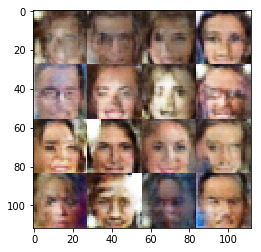

Epoch 1/1... Generator Loss: 2.4705 Discriminator Loss: 1.2295...
Epoch 1/1... Generator Loss: 0.8672 Discriminator Loss: 0.9845...
Epoch 1/1... Generator Loss: 1.7605 Discriminator Loss: 0.5846...
Epoch 1/1... Generator Loss: 0.6166 Discriminator Loss: 1.2127...
Epoch 1/1... Generator Loss: 1.2619 Discriminator Loss: 0.9064...
Epoch 1/1... Generator Loss: 0.6669 Discriminator Loss: 1.1947...
Epoch 1/1... Generator Loss: 0.7464 Discriminator Loss: 1.1328...
Epoch 1/1... Generator Loss: 1.4977 Discriminator Loss: 0.6804...
Epoch 1/1... Generator Loss: 1.1308 Discriminator Loss: 0.8441...
Epoch 1/1... Generator Loss: 0.4551 Discriminator Loss: 1.4682...


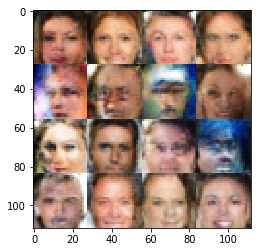

Epoch 1/1... Generator Loss: 3.0531 Discriminator Loss: 0.4283...
Epoch 1/1... Generator Loss: 2.2001 Discriminator Loss: 0.5838...
Epoch 1/1... Generator Loss: 2.7043 Discriminator Loss: 0.4630...


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.